In [15]:
import os
import pickle

import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
class HMMTraining:
    def __init__(self):
        self.class_names = [
            'A', 'Ba', 'Bài', 'Bảy', 'Bốn', 'Chậm', 'Chạy', 'Chín', 'Chủ', 'Có',
            'Cuối', 'Đầu', 'Đọc', 'Dừng', 'Đúng', 'E', 'Giảm', 'Giờ', 'Giúp', 'Hai',
            'Hủy', 'I', 'Kế', 'Không', 'Lại', 'Lặp', 'Lui', 'Lưu', 'Một', 'Mục',
            'Năm', 'Ngày', 'Ngừng', 'Nhanh', 'Nhỏ', 'O', 'Sai', 'Sáu', 'Tải', 'Tám',
            'Tăng', 'Thổ địa', 'Tiếp', 'To', 'Tới', 'Trước', 'Tuổi', 'U', 'Vào', 'Về',
            'Xóa', 'Xong'
            ]
        # số lượng trạng thái
        self.states = [
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3
            ]
        # Số lượng hỗn hợp (mix) cho từng lớp
        self.n_mix_values = {
            'A': 2, 'Ba': 2, 'Bài': 2, 'Bảy': 2, 'Bốn': 2, 'Chậm': 2, 'Chạy': 2, 'Chín': 2, 'Chủ': 2, 'Có': 2,
            'Cuối': 2, 'Đầu': 2, 'Đọc': 2, 'Dừng': 2, 'Đúng': 2, 'E': 2, 'Giảm': 2, 'Giờ': 2, 'Giúp': 2, 'Hai': 2,
            'Hủy': 2, 'I': 2, 'Kế': 2, 'Không': 2, 'Lại': 2, 'Lặp': 2, 'Lui': 2, 'Lưu': 2, 'Một': 2, 'Mục': 2,
            'Năm': 2, 'Ngày': 2, 'Ngừng': 2, 'Nhanh': 2, 'Nhỏ': 2, 'O': 2, 'Sai': 2, 'Sáu': 2, 'Tải': 2, 'Tám': 2,
            'Tăng': 2, 'Thổ địa': 2, 'Tiếp': 2, 'To': 2, 'Tới': 2, 'Trước': 2, 'Tuổi': 2, 'U': 2, 'Vào': 2, 'Về': 2,
            'Xóa': 2, 'Xong': 2
            }  
        self.dataset_path = 'datasets'

        self.X = {'train': {}, 'test': {}}
        self.y = {'train': {}, 'test': {}}

        self.model = {}
        self.model_path = 'models_train'

    def train(self):
        length = 0
        for cn in self.class_names:
            length += len(os.listdir(f"{self.dataset_path}/{cn}"))
        print('Total samples:', length)

        all_data = {}
        all_labels = {}
        for cname in self.class_names:
            file_paths = [os.path.join(self.dataset_path, cname, i) for i in os.listdir(
                os.path.join(self.dataset_path, cname)) if i.endswith('.wav')]
            data = [preprocessing.get_mfcc(file_path) for file_path in file_paths]
            all_data[cname] = data
            all_labels[cname] = [self.class_names.index(cname) for _ in range(len(file_paths))]

        for cname in self.class_names:
            x_train, x_test, y_train, y_test = train_test_split(
                all_data[cname], all_labels[cname],
                # test_size=6/14,
                test_size=0.25,
                random_state=42
            )

            self.X['train'][cname] = x_train
            self.X['test'][cname] = x_test
            self.y['test'][cname] = y_test

        total_train = 0
        total_test = 0
        for cname in self.class_names:
            train_count = len(self.X['train'][cname])
            test_count = len(self.X['test'][cname])
            print(cname, 'train:', train_count, '| test:', test_count)
            total_train += train_count
            total_test += test_count
        print('train samples:', total_train)
        print('test samples', total_test)
        
        self.log_likelihoods = {}
        for idx, cname in enumerate(self.class_names):
            start_prob = np.full(self.states[idx], 0.0)
            start_prob[0] = 1.0
            trans_matrix = np.full((self.states[idx], self.states[idx]), 0.0)
            # xac xuất chuyển trang thai
            p = 0.5
            np.fill_diagonal(trans_matrix, p)
            np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
            trans_matrix[-1, -1] = 1.0

            # trans matrix
            print(cname)
            print(trans_matrix)

            # Sử dung n_mix tu dictionary n_mix_values
            n_mix = self.n_mix_values.get(cname, 3)  # Mac Dinh la 3 neu khong co gia tri cho lop Do

            self.model[cname] = hmm.GMMHMM(
                n_components=self.states[idx],
                n_mix=n_mix,  # Sử dung so luợng hỗn hợp cho lop hiện tai
                verbose=True,
                # so lan lap
                n_iter=300,
                startprob_prior=start_prob,
                transmat_prior=trans_matrix,
                params='stmc',
                init_params='mc',
                random_state=42
            )
            self.model[cname].fit(X=np.vstack(self.X['train'][cname]),
                                  lengths=[x.shape[0] for x in self.X['train'][cname]])
            # Luu log-likelihood vao dictionary
            self.log_likelihoods[cname] = self.model[cname].monitor_.history

    def save_model(self):
        for cname in self.class_names:
            name = f'{self.model_path}/model_{cname}.pkl'
            with open(name, 'wb') as file:
                pickle.dump(self.model[cname], file)

    def evaluation(self):
        print('====== Evaluation ======')
        y_true = []
        y_pred = []
        class_accuracies = []

        # Duyệt qua tung class name
        for cname in self.class_names:
            y_true_class = []
            y_pred_class = []

            # Duyệt qua tung mẫu trong tap test
            for mfcc, target in zip(self.X['test'][cname], self.y['test'][cname]):
                # Tinh Diểm cho tung class
                scores = [self.model[c].score(mfcc) for c in self.class_names]
                pred = np.argmax(scores)
                y_pred_class.append(pred)
                y_true_class.append(target)
                y_true.append(target)
                y_pred.append(pred)

            # Tinh Do chinh xac cho tung lop
            class_accuracy = accuracy_score(y_true_class, y_pred_class)
            class_accuracies.append(class_accuracy)
            print(f'{cname}: {class_accuracy:.2f}')

        # Tinh Do chinh xac trung bình
        average_accuracy = sum(class_accuracies) / len(class_accuracies)
        print('======')
        print(f'Trung bình chung: {average_accuracy:.2f}')
        
        # Tinh ma tran nham lẫn
        cm = confusion_matrix(y_true, y_pred)

        # Vẽ ma tran nham lẫn
        plt.figure(figsize=(16, 16))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    def plot_log_likelihood(self):
        for cname in self.class_names:
            plt.figure(figsize=(8, 5))
            plt.plot(self.log_likelihoods[cname], label=f'Log-Likelihood - {cname}', color='blue')
            plt.xlabel('Iterations')
            plt.ylabel('Log-Likelihood')
            plt.title(f'Log-Likelihood Progression for {cname}')
            plt.legend()
            plt.grid()
            plt.show()

Total samples: 1040
A train: 15 | test: 5
Ba train: 15 | test: 5
Bài train: 15 | test: 5
Bảy train: 15 | test: 5
Bốn train: 15 | test: 5
Chậm train: 15 | test: 5
Chạy train: 15 | test: 5
Chín train: 15 | test: 5
Chủ train: 15 | test: 5
Có train: 15 | test: 5
Cuối train: 15 | test: 5
Đầu train: 15 | test: 5
Đọc train: 15 | test: 5
Dừng train: 15 | test: 5
Đúng train: 15 | test: 5
E train: 15 | test: 5
Giảm train: 15 | test: 5
Giờ train: 15 | test: 5
Giúp train: 15 | test: 5
Hai train: 15 | test: 5
Hủy train: 15 | test: 5
I train: 15 | test: 5
Kế train: 15 | test: 5
Không train: 15 | test: 5
Lại train: 15 | test: 5
Lặp train: 15 | test: 5
Lui train: 15 | test: 5
Lưu train: 15 | test: 5
Một train: 15 | test: 5
Mục train: 15 | test: 5
Năm train: 15 | test: 5
Ngày train: 15 | test: 5
Ngừng train: 15 | test: 5
Nhanh train: 15 | test: 5
Nhỏ train: 15 | test: 5
O train: 15 | test: 5
Sai train: 15 | test: 5
Sáu train: 15 | test: 5
Tải train: 15 | test: 5
Tám train: 15 | test: 5
Tăng train: 15 |

         1 -250215.06107809             +nan
         2 -221576.21166087  +28638.84941721
         3 -217399.34067000   +4176.87099088
         4 -214957.07455312   +2442.26611688
         5 -214075.08433290    +881.99022022
         6 -213748.96558999    +326.11874292
         7 -213602.78408255    +146.18150744
         8 -213544.90026500     +57.88381755
         9 -213503.94024935     +40.96001565
        10 -213477.93899782     +26.00125153
        11 -213471.09501098      +6.84398685
        12 -213466.96057130      +4.13443968
        13 -213462.22745607      +4.73311523
        14 -213454.31031158      +7.91714449
        15 -213441.91799735     +12.39231423
        16 -213424.79444497     +17.12355238
        17 -213411.45048456     +13.34396040
        18 -213402.64635892      +8.80412564
        19 -213397.16878627      +5.47757265
        20 -213391.58757591      +5.58121036
        21 -213383.54136273      +8.04621319
        22 -213368.81018283     +14.73117990
        23

Ba
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -256721.81990318             +nan
         2 -226367.93605522  +30353.88384795
         3 -219880.04873053   +6487.88732470
         4 -218640.23109721   +1239.81763332
         5 -218453.08970546    +187.14139175
         6 -218412.95353151     +40.13617394
         7 -218402.91590271     +10.03762880
         8 -218398.54083469      +4.37506802
         9 -218395.72899166      +2.81184303
        10 -218390.34689891      +5.38209275
        11 -218384.11665915      +6.23023976
        12 -218382.17838552      +1.93827364
        13 -218380.44148368      +1.73690184
        14 -218377.89913586      +2.54234782
        15 -218373.50910350      +4.39003236
        16 -218365.17250710      +8.33659640
        17 -218354.25695554     +10.91555156
        18 -218346.46833673      +7.78861881
        19 -218333.28442124     +13.18391548
        20 -218313.00466018     +20.27976107
        21 -218298.55992275     +14.44473742
        22 -218293.51686260      +5.04306015
        23

Bài
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         4 -212273.70413769   +1356.04969838
         5 -211649.56438698    +624.13975071
         6 -211307.69027242    +341.87411456
         7 -211155.90194006    +151.78833236
         8 -211071.32932780     +84.57261227
         9 -211007.12012542     +64.20920238
        10 -211003.42341134      +3.69671408
        11 -211002.40675666      +1.01665468
        12 -211001.80795983      +0.59879683
        13 -211001.37181418      +0.43614565
        14 -211001.05639336      +0.31542082
        15 -211000.83388059      +0.22251276
        16 -211000.68126825      +0.15261234
        17 -211000.58077066      +0.10049759
        18 -211000.51718946      +0.06358120
        19 -211000.47797028      +0.03921918
        20 -211000.45396448      +0.02400579
        21 -211000.43919021      +0.01477428
        22 -211000.42998114      +0.00920907
         1 -251529.96575152             +nan
         2 -216423.71694918  +35106.24880233
         3 -213315.31864133   +3108.39830785


Bảy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         4 -212675.25431547    +640.06432586
         5 -212292.68282874    +382.57148673
         6 -211902.24024772    +390.44258102
         7 -211727.58270039    +174.65754733
         8 -211598.27392338    +129.30877700
         9 -211508.74155442     +89.53236896
        10 -211442.39570539     +66.34584903
        11 -211399.87397491     +42.52173047
        12 -211381.39728726     +18.47668766
        13 -211372.20468494      +9.19260232
        14 -211368.87804761      +3.32663732
        15 -211367.02561304      +1.85243457
        16 -211365.70410648      +1.32150656
        17 -211364.74294591      +0.96116058
        18 -211364.12824758      +0.61469833
        19 -211363.77247644      +0.35577114
        20 -211363.57306981      +0.19940664
        21 -211363.46007008      +0.11299973
        22 -211363.39352539      +0.06654469
        23 -211363.35216968      +0.04135571
        24 -211363.32495797      +0.02721171
        25 -211363.30607735      +0.01888062
        26

Bốn
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -238815.38318637             +nan
         2 -218304.95112049  +20510.43206588
         3 -211519.86135227   +6785.08976823
         4 -209811.76922906   +1708.09212321
         5 -209467.34905951    +344.42016955
         6 -209315.61083239    +151.73822711
         7 -209193.05484281    +122.55598959
         8 -209123.92790187     +69.12694094
         9 -209117.73851270      +6.18938917
        10 -209107.94756710      +9.79094560
        11 -209102.88379831      +5.06376878
        12 -209101.89026137      +0.99353695
        13 -209101.53886234      +0.35139903
        14 -209101.36566506      +0.17319728
        15 -209101.26695157      +0.09871349
        16 -209101.20650969      +0.06044187
        17 -209101.16803122      +0.03847848
        18 -209101.14295141      +0.02507981
        19 -209101.12634093      +0.01661048
        20 -209101.11520603      +0.01113491
        21 -209101.10766771      +0.00753832


Chậm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243230.60609517             +nan
         2 -219597.40648879  +23633.19960637
         3 -210790.51903827   +8806.88745052
         4 -208795.50151175   +1995.01752652
         5 -208463.02214827    +332.47936348
         6 -208373.36268492     +89.65946335
         7 -208348.56521281     +24.79747211
         8 -208342.37930093      +6.18591188
         9 -208340.16123951      +2.21806142
        10 -208339.60310811      +0.55813140
        11 -208339.46013131      +0.14297680
        12 -208339.41319624      +0.04693507
        13 -208339.39594378      +0.01725246
        14 -208339.38913544      +0.00680835


Chạy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -244622.02366259             +nan
         2 -209020.58212190  +35601.44154068
         3 -205210.81591420   +3809.76620770
         4 -204428.21654524    +782.59936896
         5 -204035.07480045    +393.14174479
         6 -203896.37986257    +138.69493788
         7 -203852.86071346     +43.51914912
         8 -203838.58522519     +14.27548827
         9 -203828.07644801     +10.50877718
        10 -203824.45112591      +3.62532210
        11 -203822.44971034      +2.00141557
        12 -203820.60756988      +1.84214046
        13 -203773.70416452     +46.90340536
        14 -203748.30037231     +25.40379221
        15 -203734.87738721     +13.42298510
        16 -203723.57305304     +11.30433417
        17 -203706.55528908     +17.01776397
        18 -203695.67154594     +10.88374313
        19 -203691.71920108      +3.95234486
        20 -203691.53779714      +0.18140393
        21 -203691.46066667      +0.07713047
        22 -203691.41264157      +0.04802510
        23

Chín
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -227350.19529186             +nan
         2 -206146.68748919  +21203.50780267
         3 -202803.56962266   +3343.11786653
         4 -202423.68223021    +379.88739245
         5 -202364.69232702     +58.98990319
         6 -202350.15757860     +14.53474842
         7 -202345.05017996      +5.10739864
         8 -202343.24779603      +1.80238392
         9 -202342.48483060      +0.76296543
        10 -202342.11015030      +0.37468030
        11 -202341.91797955      +0.19217075
        12 -202341.81794513      +0.10003442
        13 -202341.76540023      +0.05254490
        14 -202341.73753014      +0.02787009
        15 -202341.72257974      +0.01495040
        16 -202341.71446246      +0.00811729


Chủ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -261047.98672546             +nan
         2 -224500.29000359  +36547.69672187
         3 -221049.34590233   +3450.94410126
         4 -220427.55983813    +621.78606421
         5 -220252.06073117    +175.49910696
         6 -220198.97151181     +53.08921936
         7 -220179.42654781     +19.54496400
         8 -220171.23047152      +8.19607629
         9 -220166.03204490      +5.19842662
        10 -220160.34535123      +5.68669367
        11 -220154.99423357      +5.35111766
        12 -220153.00072225      +1.99351132
        13 -220152.10123763      +0.89948462
        14 -220151.46328664      +0.63795099
        15 -220150.82861107      +0.63467557
        16 -220150.00823770      +0.82037337
        17 -220148.92551053      +1.08272717
        18 -220148.04863603      +0.87687449
        19 -220147.19545403      +0.85318200
        20 -220144.48348058      +2.71197345
        21 -220142.92737176      +1.55610882
        22 -220142.47866346      +0.44870829
        23

Có
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250974.60413848             +nan
         2 -223122.16601894  +27852.43811954
         3 -215619.65138943   +7502.51462952
         4 -214452.67721604   +1166.97417338
         5 -213914.10069972    +538.57651632
         6 -213636.77623472    +277.32446500
         7 -213514.03305971    +122.74317501
         8 -213443.31589802     +70.71716169
         9 -213410.31520279     +33.00069523
        10 -213399.50360521     +10.81159759
        11 -213395.25697463      +4.24663058
        12 -213393.44100079      +1.81597383
        13 -213392.51380543      +0.92719536
        14 -213391.95133003      +0.56247540
        15 -213391.53147855      +0.41985147
        16 -213391.12735155      +0.40412700
        17 -213390.60025300      +0.52709856
        18 -213389.69841006      +0.90184293
        19 -213388.09604299      +1.60236707
        20 -213386.20828098      +1.88776202
        21 -213385.24388386      +0.96439711
        22 -213385.07973341      +0.16415045
        23

Cuối
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237702.28673006             +nan
         2 -211720.03080476  +25982.25592530
         3 -205570.75545895   +6149.27534581
         4 -204804.98436185    +765.77109710
         5 -204635.28363582    +169.70072603
         6 -204590.09299293     +45.19064289
         7 -204568.45474941     +21.63824352
         8 -204561.18096110      +7.27378831
         9 -204558.67593967      +2.50502143
        10 -204557.65104129      +1.02489837
        11 -204557.19554411      +0.45549718
        12 -204556.98490789      +0.21063622
        13 -204556.88479292      +0.10011497
        14 -204556.83623865      +0.04855428
        15 -204556.81236048      +0.02387817
        16 -204556.80050835      +0.01185214
        17 -204556.79458796      +0.00592039


Đầu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241986.90280049             +nan
         2 -210255.18113623  +31731.72166426
         3 -205674.14503976   +4581.03609646
         4 -204828.17027823    +845.97476153
         5 -204122.01606881    +706.15420942
         6 -203917.56564298    +204.45042582
         7 -203889.35811469     +28.20752830
         8 -203881.10332029      +8.25479439
         9 -203877.78627414      +3.31704615
        10 -203876.38145424      +1.40481990
        11 -203875.70211588      +0.67933836
        12 -203875.28913673      +0.41297915
        13 -203875.00338944      +0.28574729
        14 -203874.78737790      +0.21601154
        15 -203874.61236943      +0.17500847
        16 -203874.46140638      +0.15096305
        17 -203874.32233483      +0.13907155
        18 -203874.18411395      +0.13822088
        19 -203874.03351689      +0.15059706
        20 -203873.84964316      +0.18387373
        21 -203873.59060282      +0.25904034
        22 -203873.15386210      +0.43674072
        23

Đọc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235161.47631059             +nan
         2 -202069.49358709  +33091.98272351
         3 -198211.73950633   +3857.75408075
         4 -197707.88435275    +503.85515358
         5 -197589.86766128    +118.01669148
         6 -197526.82434521     +63.04331607
         7 -197477.79167550     +49.03266971
         8 -197433.40945927     +44.38221622
         9 -197381.53764484     +51.87181444
        10 -197351.43757171     +30.10007313
        11 -197332.81876445     +18.61880726
        12 -197309.86922280     +22.94954165
        13 -197249.95095932     +59.91826348
        14 -197204.90366809     +45.04729122
        15 -197199.06547391      +5.83819418
        16 -197198.06269367      +1.00278025
        17 -197197.29646753      +0.76622614
        18 -197196.41754186      +0.87892566
        19 -197195.64659033      +0.77095153
        20 -197195.22269557      +0.42389476
        21 -197195.05232055      +0.17037502
        22 -197194.99307181      +0.05924874
        23

Dừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -238308.03193231             +nan
         2 -202909.95647301  +35398.07545930
         3 -200796.99548755   +2112.96098546
         4 -200507.07849600    +289.91699155
         5 -200391.99782935    +115.08066665
         6 -200327.59849485     +64.39933450
         7 -200292.56961735     +35.02887750
         8 -200279.02457920     +13.54503815
         9 -200263.62704830     +15.39753091
        10 -200246.40859539     +17.21845290
        11 -200229.51453970     +16.89405569
        12 -200214.04283870     +15.47170100
        13 -200208.19270473      +5.85013398
        14 -200205.15719165      +3.03551308
        15 -200203.19588832      +1.96130333
        16 -200201.67703351      +1.51885480
        17 -200200.44206874      +1.23496477
        18 -200199.40214044      +1.03992830
        19 -200198.46393642      +0.93820402
        20 -200197.45878920      +1.00514723
        21 -200195.85258765      +1.60620154
        22 -200193.54266377      +2.30992388
        23

Đúng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -234984.30885631             +nan
         2 -201957.14573959  +33027.16311672
         3 -199605.00527554   +2352.14046406
         4 -199228.78215339    +376.22312215
         5 -199137.18854856     +91.59360483
         6 -199077.42654942     +59.76199914
         7 -199032.25930989     +45.16723952
         8 -199001.12285470     +31.13645519
         9 -198967.66078805     +33.46206665
        10 -198920.97025446     +46.69053359
        11 -198832.81117475     +88.15907972
        12 -198748.54028831     +84.27088644
        13 -198694.71700406     +53.82328425
        14 -198662.08939322     +32.62761084
        15 -198637.81994304     +24.26945019
        16 -198605.03630510     +32.78363794
        17 -198542.58864707     +62.44765802
        18 -198423.35174787    +119.23689921
        19 -198277.85177912    +145.49996874
        20 -198181.83833114     +96.01344798
        21 -198114.36463743     +67.47369371
        22 -198044.11098131     +70.25365612
        23

E
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241997.45847343             +nan
         2 -216006.86425470  +25990.59421873
         3 -210392.40715088   +5614.45710382
         4 -206514.85816437   +3877.54898651
         5 -205426.01212426   +1088.84604011
         6 -205272.52579196    +153.48633230
         7 -205236.15779677     +36.36799520
         8 -205218.75463891     +17.40315785
         9 -205207.36894443     +11.38569448
        10 -205202.97761133      +4.39133310
        11 -205200.87859708      +2.09901425
        12 -205199.79568768      +1.08290939
        13 -205199.22205134      +0.57363635
        14 -205198.90942284      +0.31262850
        15 -205198.73249957      +0.17692327
        16 -205198.62703900      +0.10546058
        17 -205198.55972122      +0.06731777
        18 -205198.51307392      +0.04664730
        19 -205198.47782887      +0.03524505
        20 -205198.44901398      +0.02881490
        21 -205198.42394073      +0.02507325
        22 -205198.40115837      +0.02278236
        23

Giảm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -251187.46265030             +nan
         2 -219419.37681241  +31768.08583790
         3 -214218.01601247   +5201.36079994
         4 -213563.69772410    +654.31828836
         5 -213473.13922433     +90.55849977
         6 -213453.32568777     +19.81353657
         7 -213446.32234777      +7.00333999
         8 -213443.31151926      +3.01082851
         9 -213441.94531171      +1.36620755
        10 -213441.31939701      +0.62591469
        11 -213441.01811251      +0.30128451
        12 -213440.86325757      +0.15485493
        13 -213440.78017674      +0.08308084
        14 -213440.73461998      +0.04555676
        15 -213440.70936741      +0.02525256
        16 -213440.69528335      +0.01408407
        17 -213440.68739167      +0.00789167


Giờ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -229252.73120627             +nan
         2 -208897.49353900  +20355.23766727
         3 -204618.70163816   +4278.79190084
         4 -203654.28188364    +964.41975452
         5 -203434.49607019    +219.78581345
         6 -203350.21656489     +84.27950530
         7 -203303.47223509     +46.74432980
         8 -203271.01211680     +32.46011829
         9 -203236.72456723     +34.28754957
        10 -203223.63391980     +13.09064743
        11 -203216.34544264      +7.28847716
        12 -203213.47550340      +2.86993923
        13 -203212.49379120      +0.98171220
        14 -203212.12668973      +0.36710147
        15 -203211.97902025      +0.14766947
        16 -203211.91518483      +0.06383542
        17 -203211.88586423      +0.02932060
        18 -203211.87172001      +0.01414423
        19 -203211.86461789      +0.00710212
         1 -221687.81186067             +nan
         2 -189236.79305795  +32451.01880272
         3 -187916.34235025   +1320.45070770


Giúp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         4 -187637.26381539    +279.07853486
         5 -187551.06266857     +86.20114682
         6 -187512.70709214     +38.35557643
         7 -187485.51305669     +27.19403545
         8 -187473.62650390     +11.88655279
         9 -187466.17210593      +7.45439798
        10 -187461.04004264      +5.13206328
        11 -187458.32150142      +2.71854122
        12 -187457.96792035      +0.35358107
        13 -187457.87753296      +0.09038739
        14 -187457.85328245      +0.02425051
        15 -187457.84651443      +0.00676802


Hai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -244852.95496874             +nan
         2 -217263.83098501  +27589.12398373
         3 -212168.81502540   +5095.01595961
         4 -211597.38663329    +571.42839211
         5 -211301.98415966    +295.40247363
         6 -211167.03904842    +134.94511124
         7 -211098.64065496     +68.39839346
         8 -211076.45522414     +22.18543082
         9 -211069.58408867      +6.87113547
        10 -211066.56853689      +3.01555179
        11 -211064.49889702      +2.06963987
        12 -211062.98919113      +1.50970589
        13 -211061.12263261      +1.86655852
        14 -211055.63178806      +5.49084455
        15 -211045.10012164     +10.53166642
        16 -211037.51131794      +7.58880370
        17 -211034.30920090      +3.20211704
        18 -211031.68027367      +2.62892723
        19 -211030.28812532      +1.39214835
        20 -211029.65065524      +0.63747008
        21 -211029.30918490      +0.34147035
        22 -211029.10957945      +0.19960544
        23

Hủy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243966.69121671             +nan
         2 -212113.76285024  +31852.92836647
         3 -210200.73794889   +1913.02490136
         4 -209783.63184886    +417.10610003
         5 -209611.10653162    +172.52531724
         6 -209520.79174398     +90.31478763
         7 -209482.81584152     +37.97590247
         8 -209462.75107247     +20.06476905
         9 -209455.58938885      +7.16168362
        10 -209450.25318763      +5.33620122
        11 -209446.76824040      +3.48494723
        12 -209443.86757584      +2.90066456
        13 -209440.63778438      +3.22979146
        14 -209434.93846440      +5.69931998
        15 -209411.07387892     +23.86458549
        16 -209368.04173435     +43.03214457
        17 -209365.44545623      +2.59627812
        18 -209364.56594360      +0.87951263
        19 -209364.14546540      +0.42047819
        20 -209363.87796372      +0.26750168
        21 -209363.67936466      +0.19859906
        22 -209363.54539352      +0.13397115
        23

I
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235332.77683373             +nan
         2 -204695.52537624  +30637.25145750
         3 -199576.03368873   +5119.49168751
         4 -198788.17412507    +787.85956366
         5 -198681.19861111    +106.97551397
         6 -198649.98114002     +31.21747108
         7 -198639.68974202     +10.29139800
         8 -198635.40327888      +4.28646314
         9 -198632.04085451      +3.36242437
        10 -198629.64850111      +2.39235340
        11 -198627.32046783      +2.32803327
        12 -198624.55300325      +2.76746459
        13 -198622.20183232      +2.35117093
        14 -198619.68506502      +2.51676730
        15 -198618.15615049      +1.52891453
        16 -198617.68050461      +0.47564588
        17 -198617.35169060      +0.32881402
        18 -198617.13366913      +0.21802147
        19 -198616.98768429      +0.14598485
        20 -198616.87167468      +0.11600961
        21 -198616.71725642      +0.15441826
        22 -198615.49519595      +1.22206047
        23

Kế
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -231149.19182234             +nan
         2 -209784.29446312  +21364.89735922
         3 -207115.61606769   +2668.67839543
         4 -205828.74126406   +1286.87480363
         5 -205149.51213679    +679.22912727
         6 -204987.35202889    +162.16010790
         7 -204930.98664156     +56.36538733
         8 -204914.98729586     +15.99934570
         9 -204909.71267328      +5.27462258
        10 -204907.76739795      +1.94527533
        11 -204906.96760477      +0.79979318
        12 -204906.60718673      +0.36041804
        13 -204906.43493567      +0.17225106
        14 -204906.35025491      +0.08468076
        15 -204906.30809355      +0.04216136
        16 -204906.28698099      +0.02111256
        17 -204906.27638304      +0.01059795
        18 -204906.27106028      +0.00532276


Không
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242735.37799729             +nan
         2 -214080.77195360  +28654.60604369
         3 -210083.32524660   +3997.44670700
         4 -209674.45487709    +408.87036951
         5 -209406.86107159    +267.59380551
         6 -209235.32716744    +171.53390414
         7 -209161.98545221     +73.34171523
         8 -209106.47469535     +55.51075686
         9 -209026.15976843     +80.31492692
        10 -208917.89187950    +108.26788893
        11 -208705.44329564    +212.44858386
        12 -208316.52844315    +388.91485249
        13 -208090.37667418    +226.15176897
        14 -208040.38837088     +49.98830331
        15 -208026.08319604     +14.30517483
        16 -208020.73822244      +5.34497360
        17 -208017.50479240      +3.23343004
        18 -208015.48038835      +2.02440405
        19 -208014.33325807      +1.14713028
        20 -208013.51425622      +0.81900184
        21 -208012.68804545      +0.82621078
        22 -208012.15947166      +0.52857379
        23

Lại
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253563.52610165             +nan
         2 -219270.42447757  +34293.10162408
         3 -215869.16459346   +3401.25988411
         4 -215287.99112090    +581.17347256
         5 -215092.08636844    +195.90475245
         6 -215030.82917478     +61.25719366
         7 -215058.34286277     -27.51368799
Model is not converging.  Current: -215058.3428627686 is not greater than -215030.82917477965. Delta is -27.513687988946913


Lặp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -238053.70732110             +nan
         2 -204643.03586844  +33410.67145266
         3 -202460.67660240   +2182.35926604
         4 -202029.96455904    +430.71204336
         5 -201970.15657223     +59.80798681
         6 -201950.98160965     +19.17496258
         7 -201944.19197399      +6.78963567
         8 -201938.86952596      +5.32244802
         9 -201934.12649679      +4.74302918
        10 -201930.27957305      +3.84692374
        11 -201923.42358559      +6.85598745
        12 -201914.05493807      +9.36864753
        13 -201907.29664639      +6.75829168
        14 -201900.20747139      +7.08917499
        15 -201894.27140889      +5.93606251
        16 -201888.72624676      +5.54516212
        17 -201880.43990535      +8.28634141
        18 -201865.02080710     +15.41909825
        19 -201841.56868227     +23.45212484
        20 -201810.12104511     +31.44763716
        21 -201785.05087924     +25.07016587
        22 -201759.04668656     +26.00419268
        23

Lui
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235856.83527727             +nan
         2 -211240.81693094  +24616.01834632
         3 -208960.74020652   +2280.07672442
         4 -208338.49377436    +622.24643216
         5 -208164.93653822    +173.55723614
         6 -208096.33447835     +68.60205988
         7 -208069.31697498     +27.01750336
         8 -208041.06727042     +28.24970456
         9 -208015.96527610     +25.10199433
        10 -207990.23897379     +25.72630230
        11 -207967.20812132     +23.03085248
        12 -207951.42311825     +15.78500307
        13 -207942.63021745      +8.79290080
        14 -207936.90825497      +5.72196249
        15 -207934.02139203      +2.88686294
        16 -207932.41498296      +1.60640906
        17 -207931.46764124      +0.94734172
        18 -207930.57990768      +0.88773356
        19 -207928.94275648      +1.63715120
        20 -207926.55823146      +2.38452502
        21 -207925.36943989      +1.18879157
        22 -207925.02261367      +0.34682622
        23

Lưu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -233004.97424592             +nan
         2 -212474.89346821  +20530.08077771
         3 -204413.84900892   +8061.04445929
         4 -203170.86602636   +1242.98298255
         5 -202983.25938239    +187.60664397
         6 -202934.11360890     +49.14577349
         7 -202920.04526471     +14.06834419
         8 -202915.89116288      +4.15410183
         9 -202914.34932098      +1.54184189
        10 -202913.55152633      +0.79779465
        11 -202912.87739748      +0.67412885
        12 -202912.31880272      +0.55859476
        13 -202912.04007420      +0.27872853
        14 -202911.92572305      +0.11435114
        15 -202911.88084718      +0.04487587
        16 -202911.86270692      +0.01814026
        17 -202911.85496106      +0.00774587


Một
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -226158.73565364             +nan
         2 -207514.43600240  +18644.29965124
         3 -202225.29490724   +5289.14109516
         4 -201285.35854612    +939.93636112
         5 -201173.36423027    +111.99431585
         6 -201153.97746611     +19.38676417
         7 -201148.67144819      +5.30601792
         8 -201146.05960087      +2.61184732
         9 -201143.46327112      +2.59632975
        10 -201139.18780403      +4.27546709
        11 -201131.45329880      +7.73450523
        12 -201112.44190685     +19.01139195
        13 -201086.90137819     +25.54052866
        14 -201060.51457203     +26.38680616
        15 -201024.91118900     +35.60338302
        16 -200978.16183423     +46.74935477
        17 -200950.67628169     +27.48555254
        18 -200935.08130712     +15.59497457
        19 -200922.83245424     +12.24885288
        20 -200910.35796519     +12.47448906
        21 -200900.84791468      +9.51005050
        22 -200885.88550981     +14.96240487
        23

Mục
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -211373.60851808             +nan
         2 -191219.14213896  +20154.46637911
         3 -185412.50769089   +5806.63444807
         4 -184777.26287494    +635.24481595
         5 -184682.53371317     +94.72916177
         6 -184650.70626857     +31.82744460
         7 -184630.34288688     +20.36338169
         8 -184609.84686764     +20.49601924
         9 -184598.11469578     +11.73217185
        10 -184593.90337136      +4.21132442
        11 -184588.09794345      +5.80542791
        12 -184577.68201033     +10.41593311
        13 -184560.55068477     +17.13132556
        14 -184540.52919449     +20.02149028
        15 -184518.34266134     +22.18653315
        16 -184491.19474780     +27.14791354
        17 -184461.43169356     +29.76305424
        18 -184424.14898163     +37.28271194
        19 -184396.16159161     +27.98739002
        20 -184370.06147918     +26.10011243
        21 -184336.42224798     +33.63923121
        22 -184306.80431868     +29.61792929
        23

Năm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         5 -207497.16718450     +94.79149594
         6 -207401.61421596     +95.55296854
         7 -207256.52710677    +145.08710920
         8 -207013.46501360    +243.06209317
         9 -206742.20419823    +271.26081537
        10 -206614.01764557    +128.18655266
        11 -206576.78877724     +37.22886834
        12 -206554.83984433     +21.94893291
        13 -206530.48349746     +24.35634686
        14 -206507.00822984     +23.47526762
        15 -206495.89386256     +11.11436728
        16 -206489.39019248      +6.50367008
        17 -206484.42436622      +4.96582626
        18 -206481.77802255      +2.64634366
        19 -206480.01928221      +1.75874034
        20 -206478.71289111      +1.30639110
        21 -206477.56950196      +1.14338915
        22 -206476.96693890      +0.60256306
        23 -206476.72782917      +0.23910973
        24 -206476.60128854      +0.12654063
        25 -206476.52517569      +0.07611285
        26 -206476.47537974      +0.04979595
        27

Ngày
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -239236.56138599             +nan
         2 -211156.71833790  +28079.84304809
         3 -206777.43922987   +4379.27910803
         4 -206145.23815957    +632.20107030
         5 -205992.53117480    +152.70698477
         6 -205903.75109267     +88.78008213
         7 -205798.56146982    +105.18962285
         8 -205649.79013863    +148.77133119
         9 -205528.52723391    +121.26290471
        10 -205446.30723644     +82.21999747
        11 -205422.12027176     +24.18696468
        12 -205411.10496493     +11.01530683
        13 -205404.27743306      +6.82753187
        14 -205400.55324878      +3.72418428
        15 -205396.41438314      +4.13886564
        16 -205393.74703224      +2.66735090
        17 -205392.88345370      +0.86357855
        18 -205392.46451803      +0.41893567
        19 -205392.15030346      +0.31421457
        20 -205391.76706967      +0.38323379
        21 -205391.32320032      +0.44386935
        22 -205391.00099945      +0.32220087
        23

Ngừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -229868.55873364             +nan
         2 -199700.77488545  +30167.78384819
         3 -198025.67373701   +1675.10114844
         4 -197693.20157474    +332.47216227
         5 -197512.72688317    +180.47469156
         6 -197390.31889184    +122.40799134
         7 -197341.71331754     +48.60557430
         8 -197313.87232003     +27.84099751
         9 -197286.73364383     +27.13867620
        10 -197266.76487248     +19.96877135
        11 -197251.45197098     +15.31290151
        12 -197238.13385922     +13.31811175
        13 -197224.52534148     +13.60851774
        14 -197205.78111070     +18.74423078
        15 -197201.24561589      +4.53549481
        16 -197192.06352685      +9.18208904
        17 -197183.00653539      +9.05699146
        18 -197172.05182917     +10.95470622
        19 -197153.52991196     +18.52191721
        20 -197134.13794158     +19.39197038
        21 -197110.35781291     +23.78012867
        22 -197079.74886407     +30.60894884
        23

Nhanh
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -246908.58782511             +nan
         2 -212943.37602542  +33965.21179969
         3 -210854.76694762   +2088.60907780
         4 -210581.33998240    +273.42696522
         5 -210436.47394794    +144.86603447
         6 -210323.80245617    +112.67149176
         7 -210270.42256705     +53.37988912
         8 -210248.25951529     +22.16305177
         9 -210232.46396904     +15.79554625
        10 -210211.17321063     +21.29075840
        11 -210197.28027054     +13.89294010
        12 -210189.08938270      +8.19088784
        13 -210185.86443690      +3.22494579
        14 -210181.10144376      +4.76299314
        15 -210178.27629594      +2.82514783
        16 -210177.84133840      +0.43495754
        17 -210177.63613673      +0.20520167
        18 -210177.50200437      +0.13413236
        19 -210177.37563612      +0.12636825
        20 -210177.18732401      +0.18831211
        21 -210176.88073517      +0.30658884
        22 -210176.63450284      +0.24623233
        23

Nhỏ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253885.97813367             +nan
         2 -233508.01927246  +20377.95886121
         3 -227030.15017143   +6477.86910103
         4 -225037.47202094   +1992.67815049
         5 -223304.45311060   +1733.01891034
         6 -222664.06791890    +640.38519170
         7 -222430.91057251    +233.15734639
         8 -222347.43337046     +83.47720206
         9 -222309.10760730     +38.32576316
        10 -222290.42901554     +18.67859176
        11 -222283.04032398      +7.38869156
        12 -222279.62937032      +3.41095366
        13 -222277.77138391      +1.85798641
        14 -222276.74173936      +1.02964455
        15 -222276.17439173      +0.56734764
        16 -222275.86373636      +0.31065536
        17 -222275.69396394      +0.16977243
        18 -222275.60110406      +0.09285988
        19 -222275.55020233      +0.05090173
        20 -222275.52222204      +0.02798029
        21 -222275.50679206      +0.01542998
        22 -222275.49825209      +0.00853997


O
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -245171.36975992             +nan
         2 -220573.67930524  +24597.69045468
         3 -213810.94619983   +6762.73310542
         4 -211258.25966835   +2552.68653147
         5 -210243.84404396   +1014.41562440
         6 -209879.05716881    +364.78687515
         7 -209756.95261461    +122.10455420
         8 -209711.72403852     +45.22857609
         9 -209696.30584549     +15.41819303
        10 -209691.15302325      +5.15282224
        11 -209689.32286062      +1.83016263
        12 -209688.63942126      +0.68343936
        13 -209688.37727140      +0.26214986
        14 -209688.27533443      +0.10193698
        15 -209688.23537014      +0.03996429
        16 -209688.21959869      +0.01577145
        17 -209688.21333155      +0.00626714
         1 -245198.98855272             +nan
         2 -227217.97973406  +17981.00881866
         3 -219028.93178100   +8189.04795306


Sai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         4 -216175.13612373   +2853.79565727
         5 -215498.27919996    +676.85692377
         6 -215218.91682257    +279.36237739
         7 -215136.87601705     +82.04080552
         8 -214993.38795506    +143.48806199
         9 -214762.26818198    +231.11977308
        10 -214621.32325035    +140.94493164
        11 -214588.82961698     +32.49363337
        12 -214563.24990155     +25.57971543
        13 -214553.37548153      +9.87442002
        14 -214551.90929766      +1.46618387
        15 -214551.36189133      +0.54740633
        16 -214551.06811451      +0.29377682
        17 -214550.88935540      +0.17875911
        18 -214550.77206188      +0.11729352
        19 -214550.69104689      +0.08101499
        20 -214550.63261760      +0.05842929
        21 -214550.58884845      +0.04376914
        22 -214550.55499740      +0.03385106
        23 -214550.52813296      +0.02686444
        24 -214550.50638003      +0.02175293
        25 -214550.48849498      +0.01788505
        26

Sáu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243811.96166316             +nan
         2 -224833.45839452  +18978.50326864
         3 -217899.07720896   +6934.38118556
         4 -214394.57927246   +3504.49793649
         5 -213425.46702493    +969.11224753
         6 -213265.46912295    +159.99790198
         7 -213232.34751438     +33.12160857
         8 -213219.79089430     +12.55662008
         9 -213213.95950414      +5.83139016
        10 -213211.54676080      +2.41274334
        11 -213210.58289965      +0.96386116
        12 -213210.13715908      +0.44574057
        13 -213209.89604808      +0.24111100
        14 -213209.77153264      +0.12451544
        15 -213209.71817837      +0.05335427
        16 -213209.69633419      +0.02184418
        17 -213209.68674775      +0.00958644
         1 -238301.08135699             +nan
         2 -209556.93257675  +28744.14878024
         3 -204490.01132767   +5066.92124908
         4 -203765.66471532    +724.34661235


Tải
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         5 -203311.38354784    +454.28116747
         6 -202611.85224923    +699.53129862
         7 -201463.92994893   +1147.92230030
         8 -200716.01391020    +747.91603872
         9 -200490.20200083    +225.81190938
        10 -200345.76670800    +144.43529283
        11 -200247.95675708     +97.80995092
        12 -200194.82725341     +53.12950367
        13 -200169.65180463     +25.17544879
        14 -200154.69434483     +14.95745980
        15 -200145.57423907      +9.12010576
        16 -200138.32247424      +7.25176483
        17 -200133.33206878      +4.99040546
        18 -200129.72469089      +3.60737789
        19 -200127.41002042      +2.31467048
        20 -200126.36472769      +1.04529273
        21 -200125.87439442      +0.49033327
        22 -200125.54531636      +0.32907805
        23 -200125.26940046      +0.27591590
        24 -200125.04195152      +0.22744894
        25 -200124.88000192      +0.16194960
        26 -200124.77827238      +0.10172954
        27

Tám
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -251922.89300247             +nan
         2 -219422.30478228  +32500.58822019
         3 -214691.94266579   +4730.36211649
         4 -213793.36794134    +898.57472445
         5 -213607.46838252    +185.89955882
         6 -213552.09197714     +55.37640538
         7 -213529.77460837     +22.31736877
         8 -213519.71166203     +10.06294634
         9 -213514.74452299      +4.96713904
        10 -213512.20344873      +2.54107426
        11 -213510.86845768      +1.33499105
        12 -213510.14636422      +0.72209347
        13 -213509.74517662      +0.40118759
        14 -213509.51710823      +0.22806839
        15 -213509.38511675      +0.13199149
        16 -213509.30776735      +0.07734939
        17 -213509.26205959      +0.04570776
        18 -213509.23488485      +0.02717475
        19 -213509.21864169      +0.01624316
        20 -213509.20888024      +0.00976145


Tăng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -244306.46707273             +nan
         2 -222589.76157471  +21716.70549802
         3 -215661.25570714   +6928.50586756
         4 -212752.94909000   +2908.30661714
         5 -211286.57545325   +1466.37363675
         6 -210667.07921892    +619.49623433
         7 -210375.18248676    +291.89673216
         8 -210123.41027268    +251.77221408
         9 -209849.89521491    +273.51505777
        10 -209760.46048156     +89.43473334
        11 -209752.61933993      +7.84114164
        12 -209750.00384970      +2.61549022
        13 -209748.93887367      +1.06497603
        14 -209748.45674895      +0.48212472
        15 -209748.22687192      +0.22987703
        16 -209748.11577163      +0.11110029
        17 -209748.06302684      +0.05274479
        18 -209748.03860352      +0.02442332
        19 -209748.02744549      +0.01115803
        20 -209748.02234929      +0.00509620


Thổ địa
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -284141.60417325             +nan
         2 -253943.33302776  +30198.27114549
         3 -250461.85852053   +3481.47450723
         4 -249210.55108652   +1251.30743400
         5 -248700.51608444    +510.03500208
         6 -248407.77647667    +292.73960778
         7 -248182.45531382    +225.32116285
         8 -248014.17692826    +168.27838556
         9 -247881.52080728    +132.65612098
        10 -247716.81188125    +164.70892603
        11 -247537.95779873    +178.85408252
        12 -247403.45113914    +134.50665958
        13 -247303.35560588    +100.09553327
        14 -247223.96353263     +79.39207324
        15 -247134.07242559     +89.89110704
        16 -246965.25486147    +168.81756413
        17 -246671.21071745    +294.04414402
        18 -246481.40533741    +189.80538004
        19 -246419.34089089     +62.06444652
        20 -246382.64521982     +36.69567107
        21 -246357.89795767     +24.74726215
        22 -246342.31118074     +15.58677693
        23

Tiếp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -229232.80332098             +nan
         2 -196399.01834593  +32833.78497505
         3 -193635.10059508   +2763.91775085
         4 -192648.84005729    +986.26053780
         5 -192278.06514936    +370.77490793
         6 -192128.94454373    +149.12060563
         7 -192034.47928454     +94.46525919
         8 -191995.98585407     +38.49343047
         9 -191975.66196558     +20.32388849
        10 -191965.34019691     +10.32176867
        11 -191956.59156267      +8.74863424
        12 -191945.91088698     +10.68067570
        13 -191934.22658391     +11.68430307
        14 -191910.89698905     +23.32959486
        15 -191854.83814033     +56.05884872
        16 -191803.84213687     +50.99600346
        17 -191764.36156470     +39.48057217
        18 -191752.84659827     +11.51496642
        19 -191741.49576659     +11.35083168
        20 -191724.03145111     +17.46431548
        21 -191674.83542932     +49.19602179
        22 -191624.13511082     +50.70031850
        23

To
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253127.91299458             +nan
         2 -227858.17880182  +25269.73419276
         3 -219806.31426651   +8051.86453531
         4 -217964.29070344   +1842.02356307
         5 -217725.98701997    +238.30368347
         6 -217681.35572158     +44.63129839
         7 -217667.10742975     +14.24829183
         8 -217662.09803161      +5.00939814
         9 -217660.02738719      +2.07064442
        10 -217658.93239258      +1.09499461
        11 -217658.25117622      +0.68121636
        12 -217657.98843766      +0.26273856
        13 -217657.90538297      +0.08305469
        14 -217657.87623832      +0.02914465
        15 -217657.86600214      +0.01023618
        16 -217657.86260273      +0.00339941


Tới
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237501.72031024             +nan
         2 -217317.99650753  +20183.72380271
         3 -212016.79078631   +5301.20572122
         4 -209987.43999802   +2029.35078829
         5 -209448.38279430    +539.05720372
         6 -209244.32062618    +204.06216811
         7 -209148.85146917     +95.46915701
         8 -209107.09369272     +41.75777645
         9 -209085.37807891     +21.71561381
        10 -209066.09312296     +19.28495595
        11 -209048.20600372     +17.88711925
        12 -209036.06385733     +12.14214638
        13 -209025.37153769     +10.69231964
        14 -209005.57371224     +19.79782546
        15 -208990.68485853     +14.88885371
        16 -208977.32949386     +13.35536467
        17 -208970.99271781      +6.33677605
        18 -208963.51265481      +7.48006300
        19 -208945.26135414     +18.25130066
        20 -208925.08670641     +20.17464774
        21 -208909.71650661     +15.37019979
        22 -208899.00185676     +10.71464986
        23

Trước
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240160.65175571             +nan
         2 -208685.49663747  +31475.15511824
         3 -204754.61773848   +3930.87889900
         4 -204068.26321811    +686.35452037
         5 -203179.90758465    +888.35563346
         6 -202139.45210921   +1040.45547543
         7 -201527.37824547    +612.07386375
         8 -201333.26627576    +194.11196971
         9 -201270.48106864     +62.78520712
        10 -201247.62494600     +22.85612264
        11 -201236.18854024     +11.43640577
        12 -201229.70147695      +6.48706329
        13 -201225.50409136      +4.19738558
        14 -201222.37064270      +3.13344866
        15 -201219.89333067      +2.47731204
        16 -201217.55963397      +2.33369670
        17 -201214.64348879      +2.91614518
        18 -201210.40835142      +4.23513737
        19 -201200.89602616      +9.51232526
        20 -201173.20842621     +27.68759996
        21 -201152.25658823     +20.95183798
        22 -201145.62661416      +6.62997406
        23

Tuổi
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -205946.46126248   +3544.74546192
         4 -204784.01753875   +1162.44372373
         5 -204415.48553112    +368.53200763
         6 -204339.53373838     +75.95179274
         7 -204312.35647956     +27.17725882
         8 -204302.62856487      +9.72791469
         9 -204298.42487988      +4.20368500
        10 -204296.28474024      +2.14013964
        11 -204295.03048601      +1.25425423
        12 -204294.08160428      +0.94888173
        13 -204293.12100968      +0.96059460
        14 -204291.93084956      +1.19016012
        15 -204290.69273863      +1.23811093
        16 -204289.99534158      +0.69739706
        17 -204289.74370672      +0.25163486
        18 -204289.63664717      +0.10705955
        19 -204289.56815683      +0.06849034
        20 -204289.51225069      +0.05590614
        21 -204289.46313950      +0.04911120
        22 -204289.42009551      +0.04304399
        23 -204289.38326136      +0.03683415
        24 -204289.35242224      +0.03083912
        25

U
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -224421.56947639             +nan
         2 -204439.89568574  +19981.67379065
         3 -196947.77475182   +7492.12093392
         4 -194815.03258918   +2132.74216264
         5 -194456.67024960    +358.36233958
         6 -194365.58582702     +91.08442258
         7 -194338.09924460     +27.48658242
         8 -194321.24757923     +16.85166537
         9 -194310.52824575     +10.71933347
        10 -194306.09451705      +4.43372870
        11 -194302.02910602      +4.06541104
        12 -194297.24715466      +4.78195136
        13 -194294.89807201      +2.34908265
        14 -194294.17248274      +0.72558927
        15 -194293.89902983      +0.27345291
        16 -194293.79588764      +0.10314219
        17 -194293.75674529      +0.03914235
        18 -194293.74131279      +0.01543250
        19 -194293.73499475      +0.00631804
         1 -239912.85074452             +nan
         2 -214321.98603071  +25590.86471382


Vào
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -207263.21835314   +7058.76767756
         4 -206048.34891580   +1214.86943734
         5 -205668.85753081    +379.49138499
         6 -205488.43639541    +180.42113540
         7 -205395.56198698     +92.87440843
         8 -205302.24433733     +93.31764965
         9 -205218.87012809     +83.37420923
        10 -205125.47280021     +93.39732789
        11 -205063.07715216     +62.39564805
        12 -205029.37445079     +33.70270137
        13 -205008.01037432     +21.36407647
        14 -204998.29943831      +9.71093601
        15 -204991.61792672      +6.68151158
        16 -204984.85870268      +6.75922404
        17 -204978.13923901      +6.71946367
        18 -204971.09714211      +7.04209690
        19 -204962.59123910      +8.50590302
        20 -204950.21381515     +12.37742395
        21 -204928.29009488     +21.92372027
        22 -204881.84193774     +46.44815714
        23 -204837.26280221     +44.57913552
        24 -204810.45299254     +26.80980967
        25

Về
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -229668.22552142             +nan
         2 -200164.65156514  +29503.57395628
         3 -197372.95521937   +2791.69634577
         4 -196833.20654514    +539.74867423
         5 -196677.57381833    +155.63272681
         6 -196602.32108056     +75.25273777
         7 -196542.52315806     +59.79792250
         8 -196507.20161174     +35.32154631
         9 -196492.08264774     +15.11896401
        10 -196485.27003827      +6.81260947
        11 -196481.48182482      +3.78821345
        12 -196480.29013097      +1.19169385
        13 -196479.39803649      +0.89209448
        14 -196478.52927873      +0.86875776
        15 -196477.27574145      +1.25353728
        16 -196476.30898478      +0.96675666
        17 -196476.05683156      +0.25215323
        18 -196476.02323632      +0.03359523
        19 -196476.01468572      +0.00855060


Xóa
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253864.61268208             +nan
         2 -225127.35447617  +28737.25820591
         3 -222210.26013041   +2917.09434576
         4 -221694.51989026    +515.74024015
         5 -221123.00330445    +571.51658581
         6 -220812.61070916    +310.39259529
         7 -220713.36760944     +99.24309972
         8 -220653.04839967     +60.31920977
         9 -220596.61207546     +56.43632421
        10 -220562.17933914     +34.43273632
        11 -220541.19029022     +20.98904892
        12 -220531.57288403      +9.61740619
        13 -220523.19197593      +8.38090810
        14 -220511.32306348     +11.86891245
        15 -220504.35179326      +6.97127022
        16 -220501.54821198      +2.80358128
        17 -220499.70253217      +1.84567981
        18 -220498.35490995      +1.34762222
        19 -220497.60627223      +0.74863772
        20 -220497.23182642      +0.37444581
        21 -220497.05021306      +0.18161335
        22 -220496.97231119      +0.07790188
        23

Xong
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -251457.63295925             +nan
         2 -227585.69280743  +23871.94015183
         3 -220031.54970841   +7554.14309902
         4 -218662.73815723   +1368.81155118
         5 -218396.70660619    +266.03155104
         6 -218306.60371195     +90.10289424
         7 -218238.36357968     +68.24013227
         8 -218141.29565255     +97.06792713
         9 -218047.41990084     +93.87575170
        10 -217953.07916631     +94.34073453
        11 -217887.93760121     +65.14156510
        12 -217872.49658498     +15.44101623
        13 -217866.28280009      +6.21378489
        14 -217864.23501697      +2.04778311
        15 -217862.96232525      +1.27269172
        16 -217862.08879913      +0.87352612
        17 -217861.65583564      +0.43296349
        18 -217861.47181237      +0.18402327
        19 -217861.39191352      +0.07989885
        20 -217861.35591229      +0.03600123
        21 -217861.33912400      +0.01678829
        22 -217861.33105420      +0.00806980


====== Evaluation ======
A: 0.60
Ba: 0.40
Bài: 0.60
Bảy: 0.60
Bốn: 0.60
Chậm: 0.60
Chạy: 0.60
Chín: 0.80
Chủ: 1.00
Có: 0.60
Cuối: 1.00
Đầu: 0.40
Đọc: 0.60
Dừng: 0.80
Đúng: 0.60
E: 0.60
Giảm: 0.60
Giờ: 0.80
Giúp: 0.80
Hai: 0.60
Hủy: 0.60
I: 0.60
Kế: 0.60
Không: 0.60
Lại: 0.60
Lặp: 0.80
Lui: 0.40
Lưu: 0.60
Một: 0.60
Mục: 0.80
Năm: 0.60
Ngày: 0.60
Ngừng: 0.80
Nhanh: 0.60
Nhỏ: 0.60
O: 0.00
Sai: 0.40
Sáu: 0.80
Tải: 0.60
Tám: 0.60
Tăng: 0.60
Thổ địa: 1.00
Tiếp: 0.60
To: 0.60
Tới: 0.60
Trước: 0.80
Tuổi: 0.20
U: 0.80
Vào: 0.60
Về: 0.80
Xóa: 0.40
Xong: 0.00
Trung bình chung: 0.62


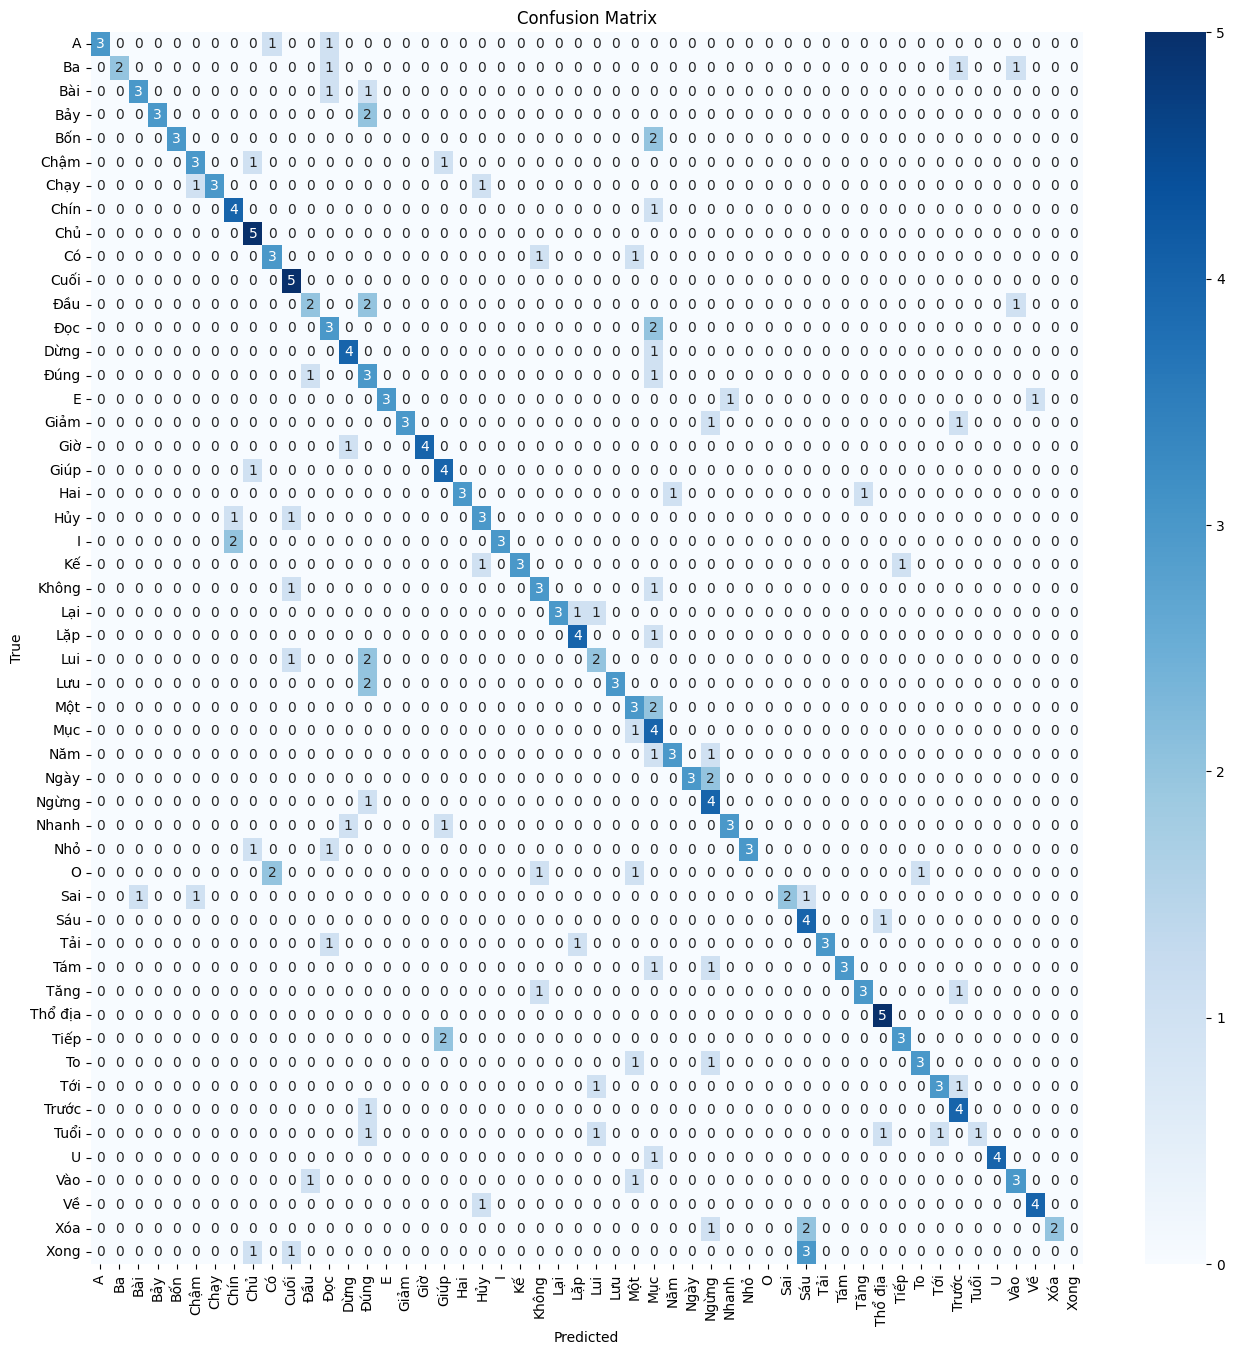

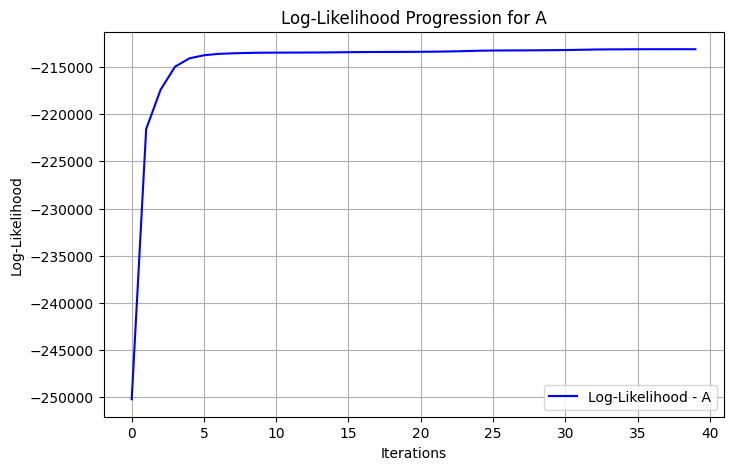

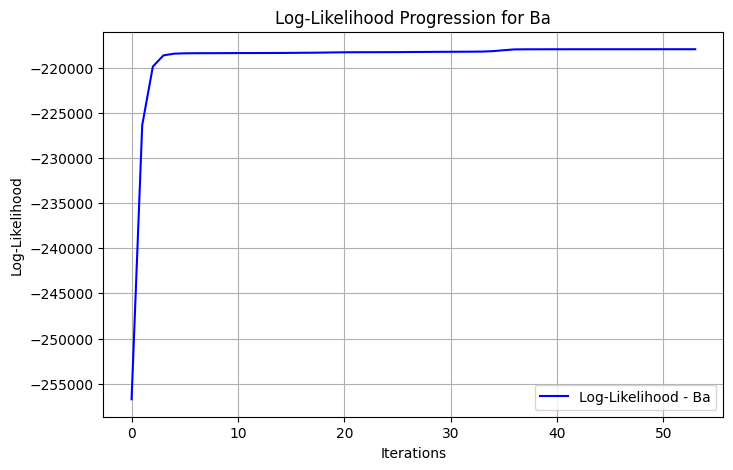

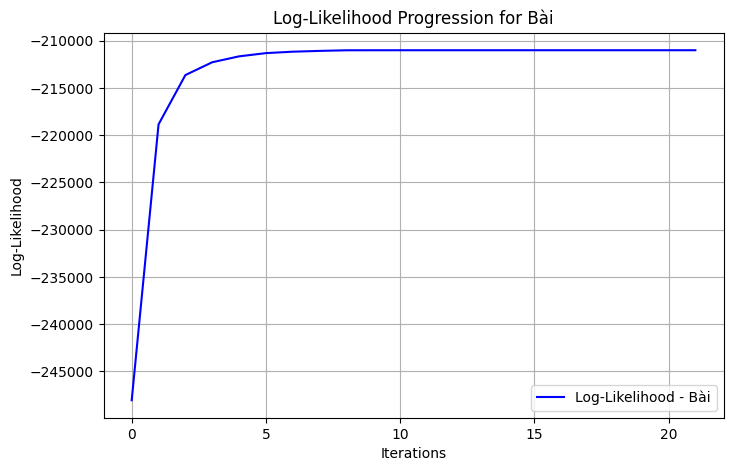

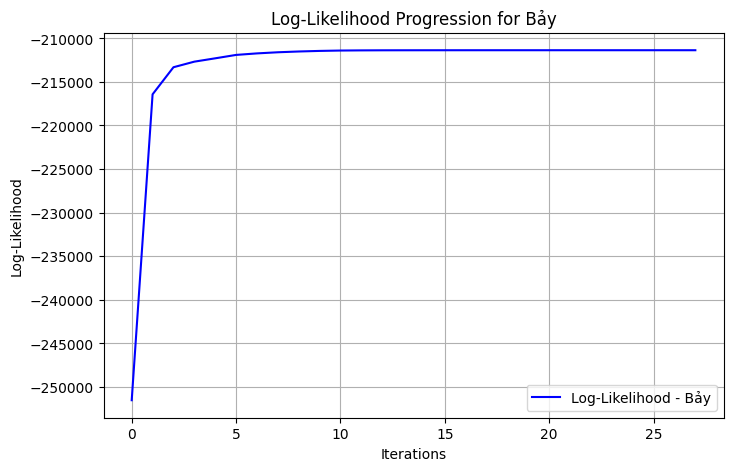

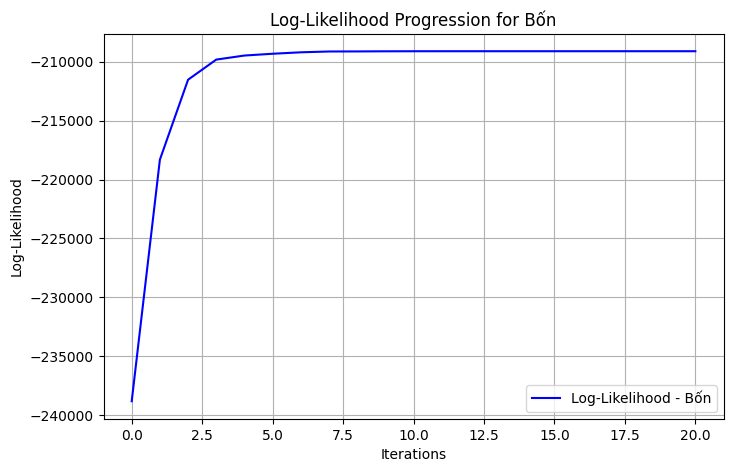

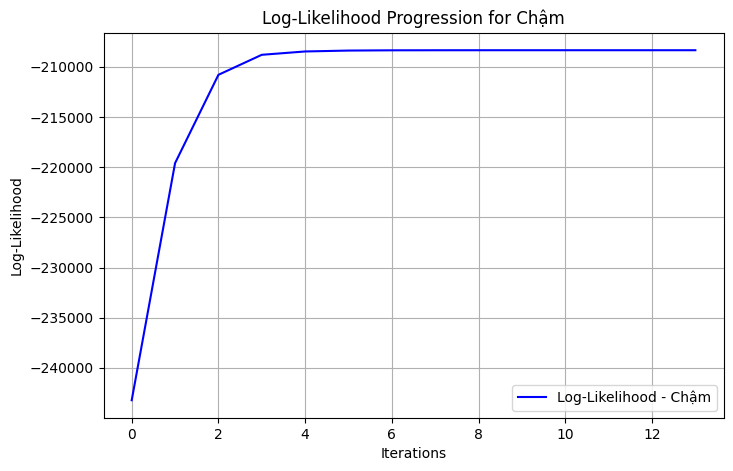

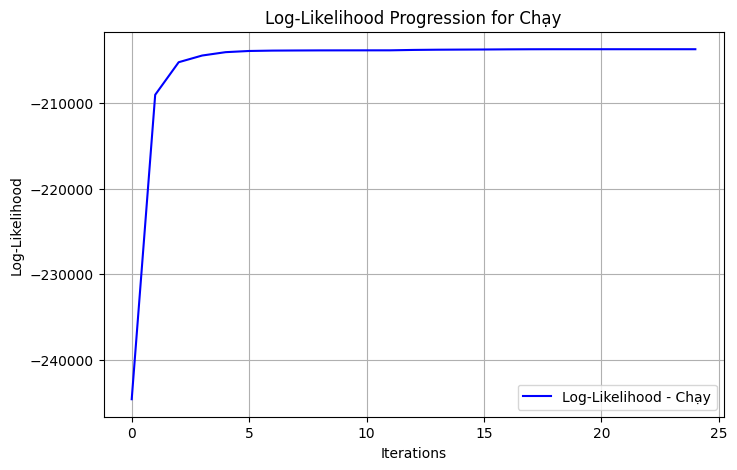

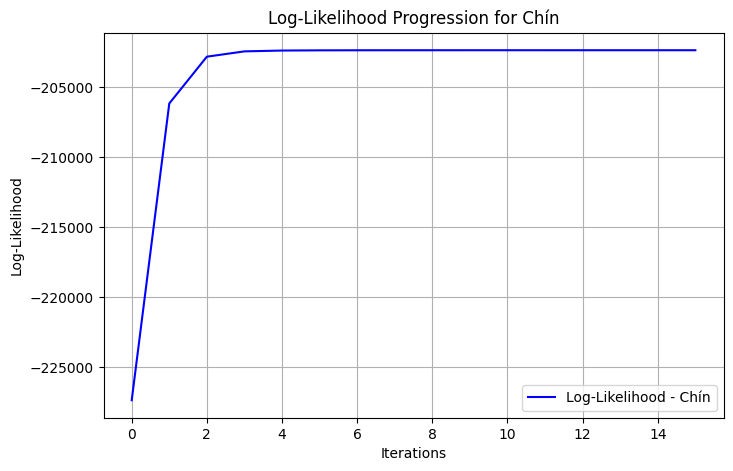

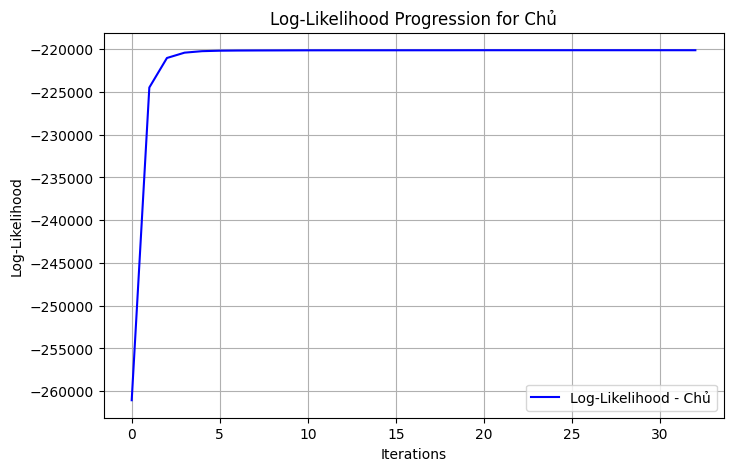

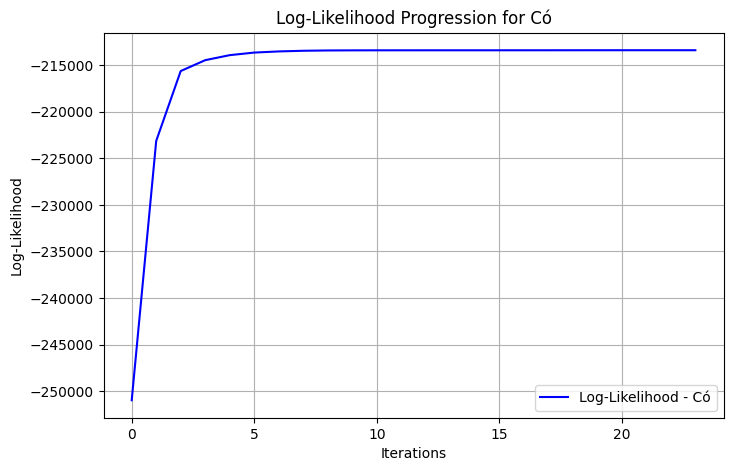

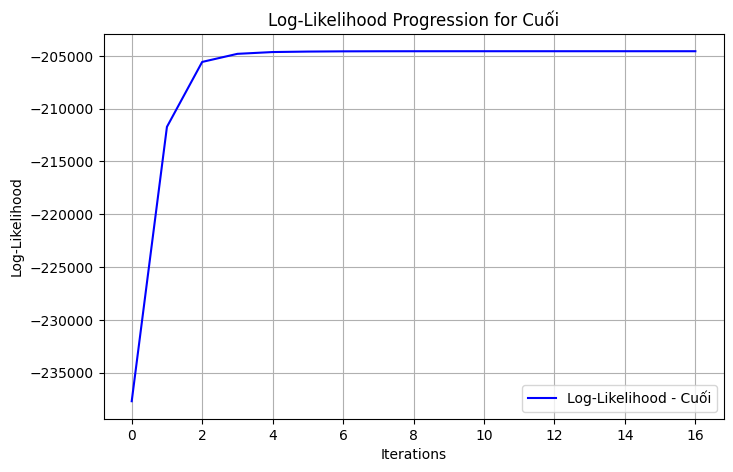

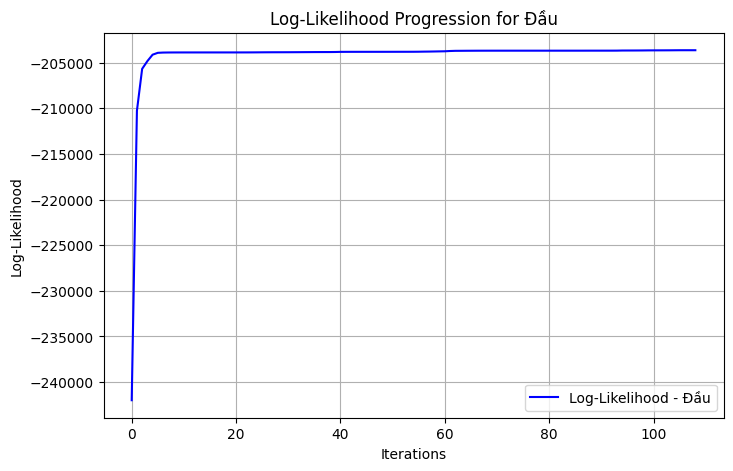

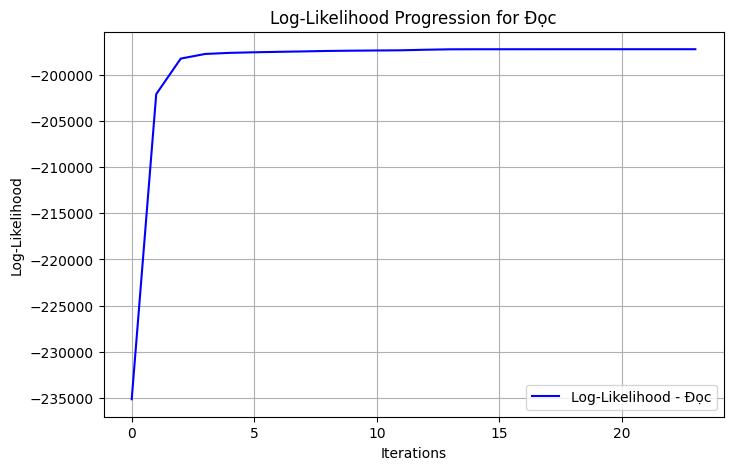

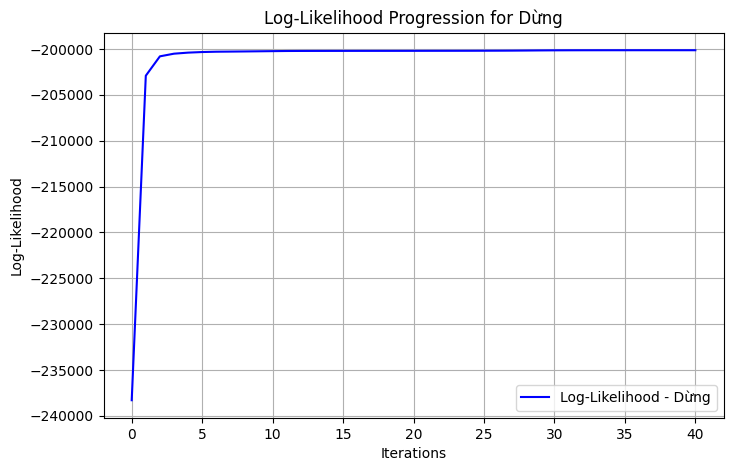

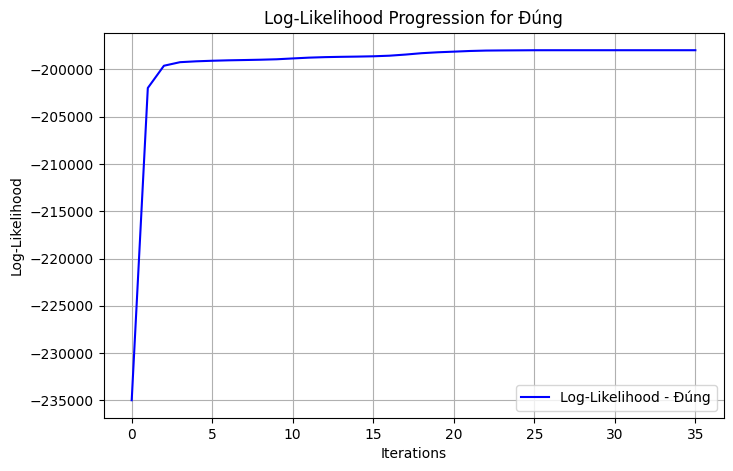

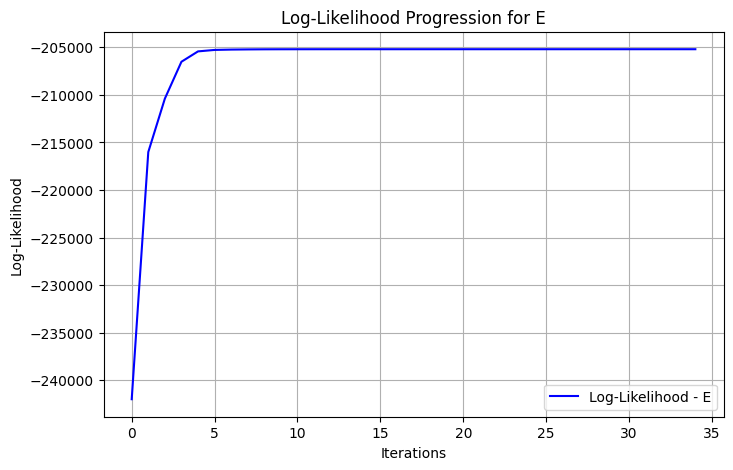

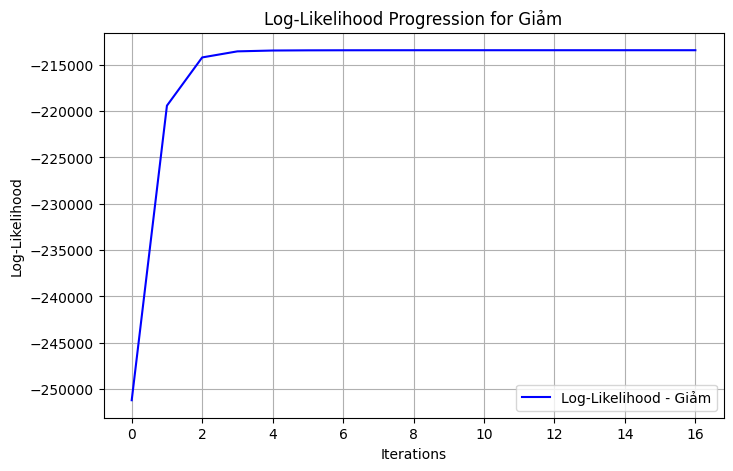

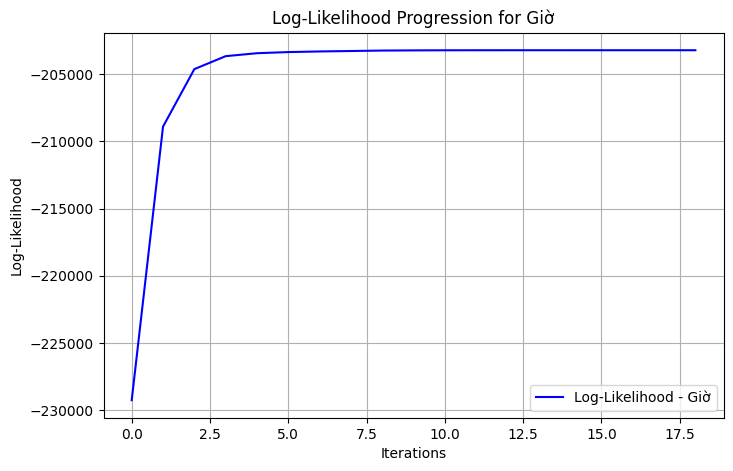

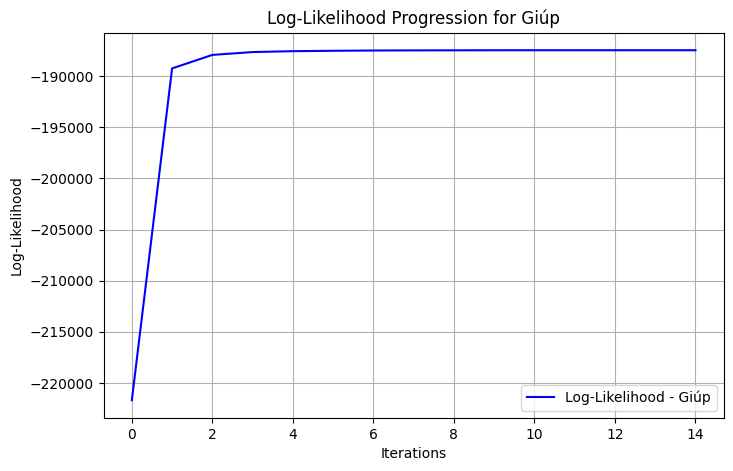

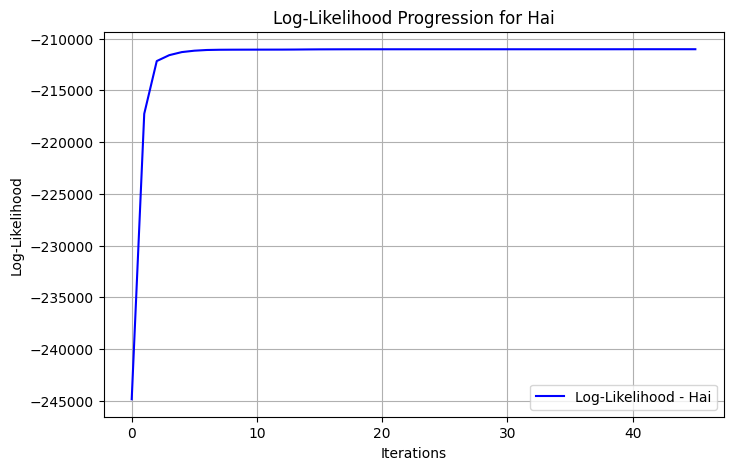

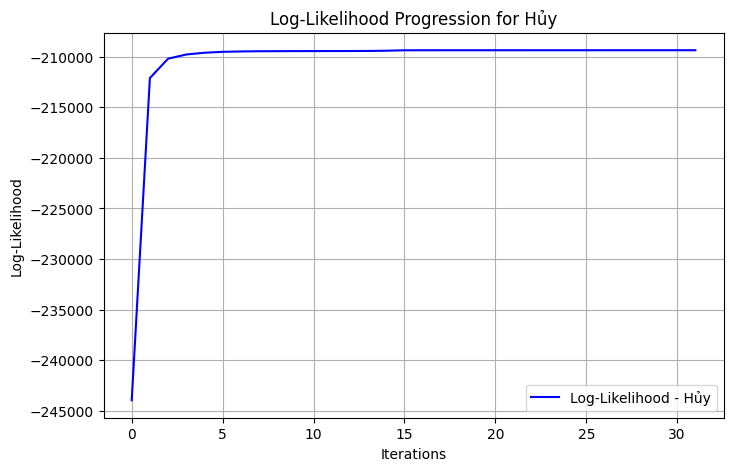

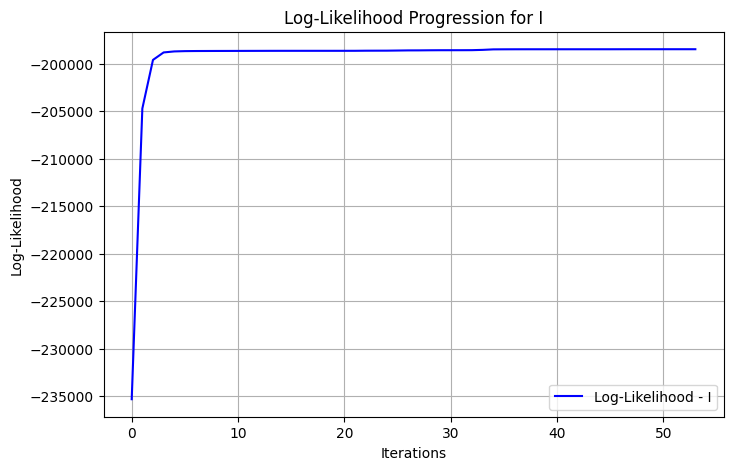

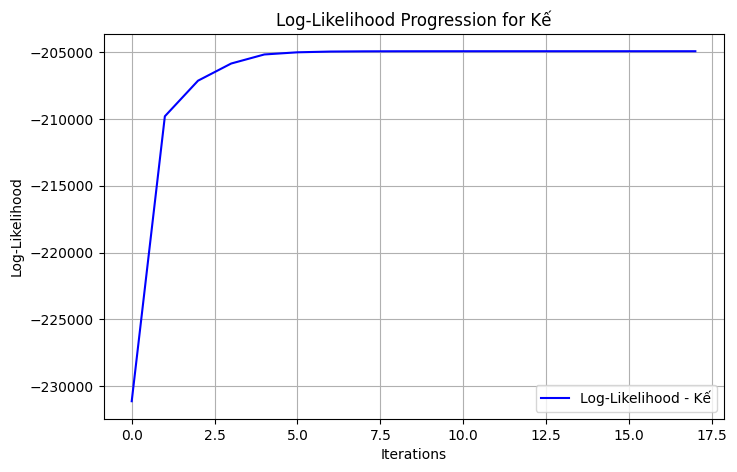

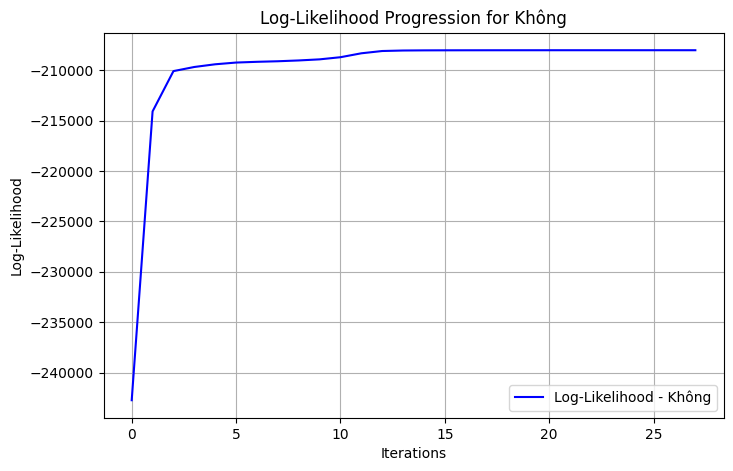

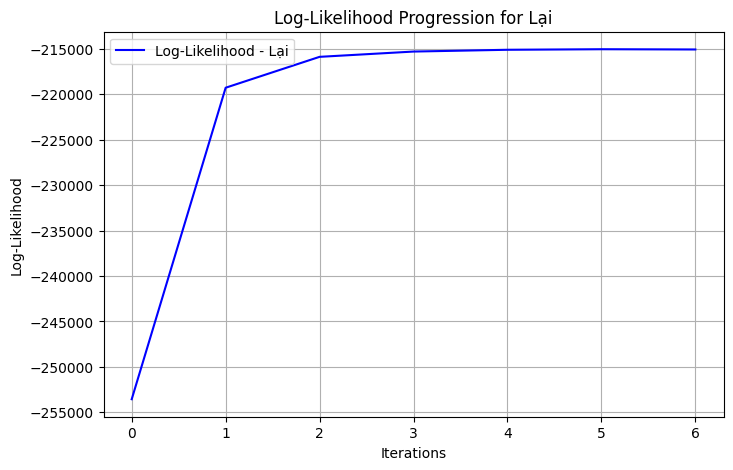

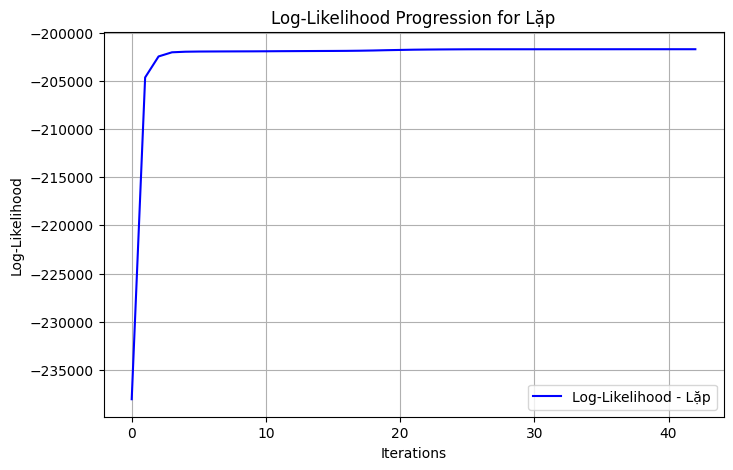

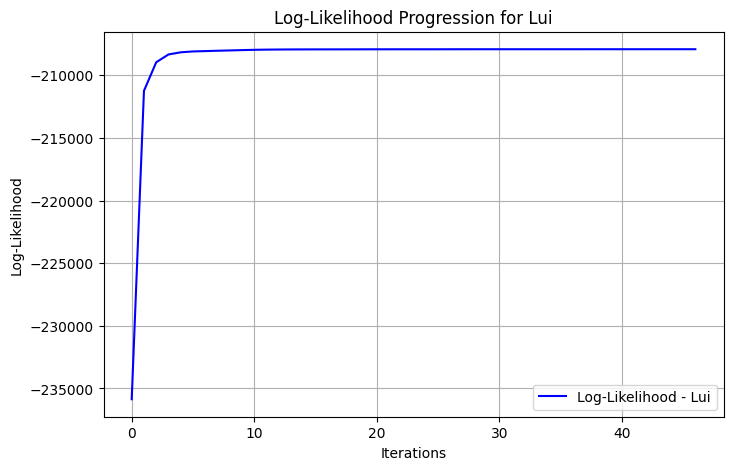

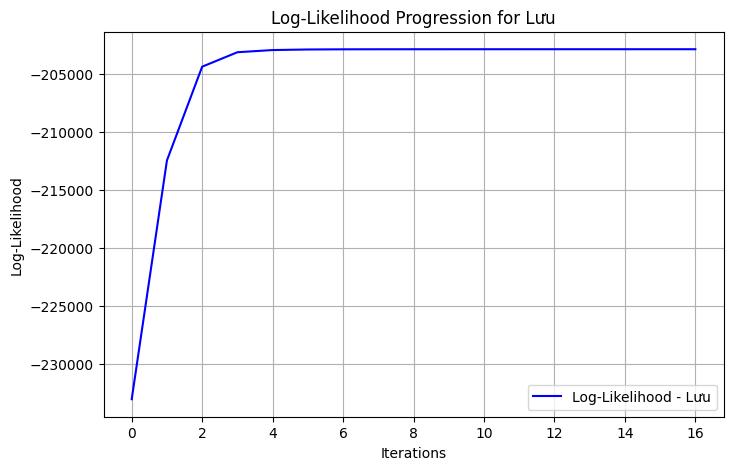

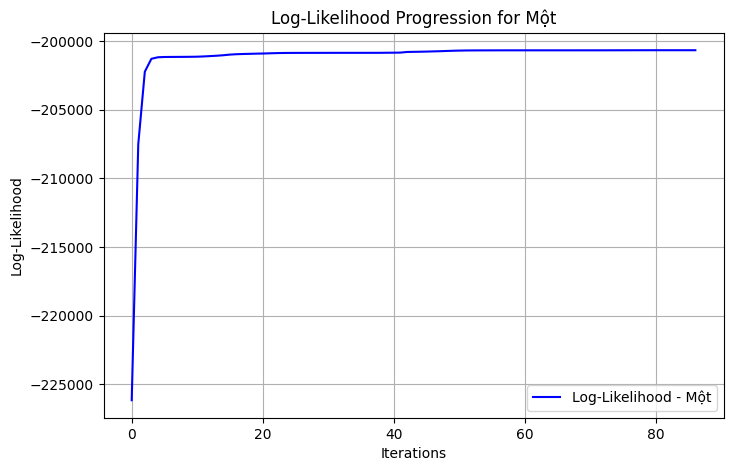

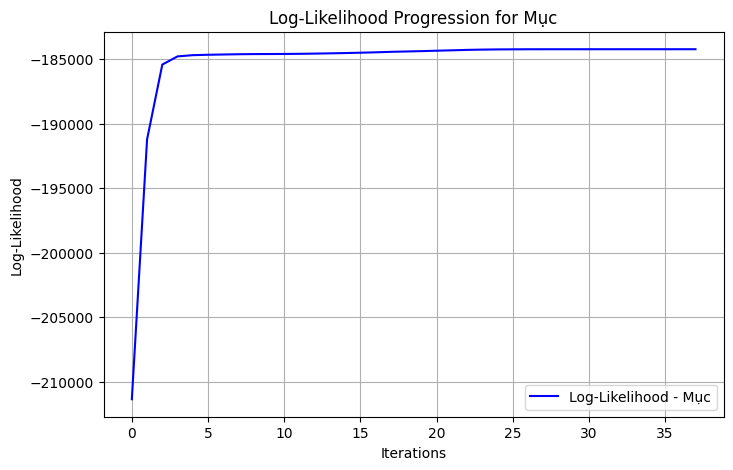

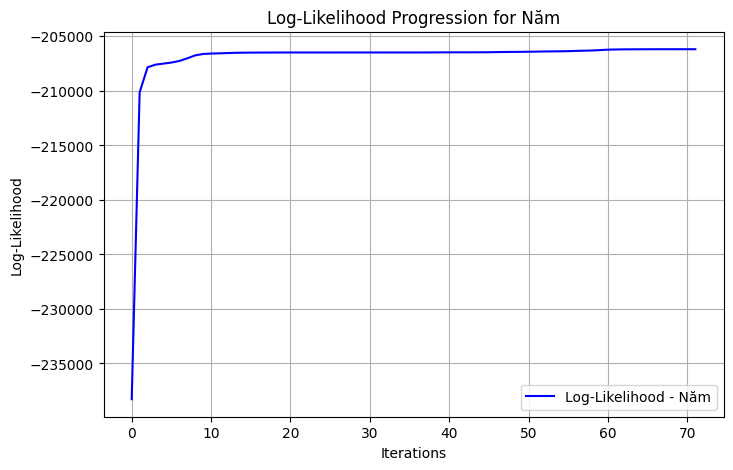

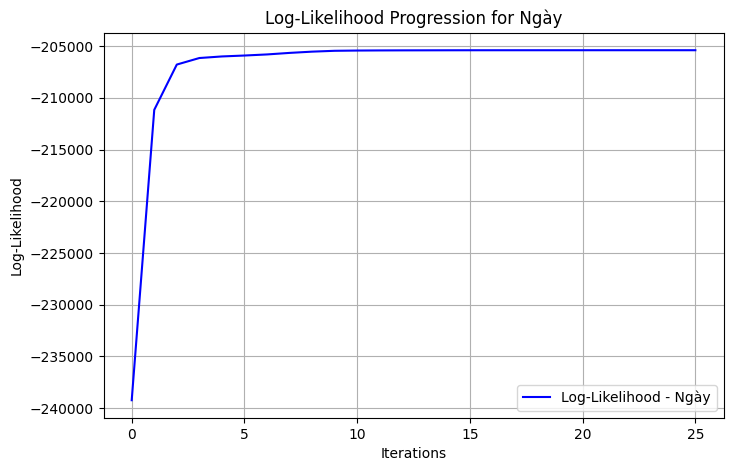

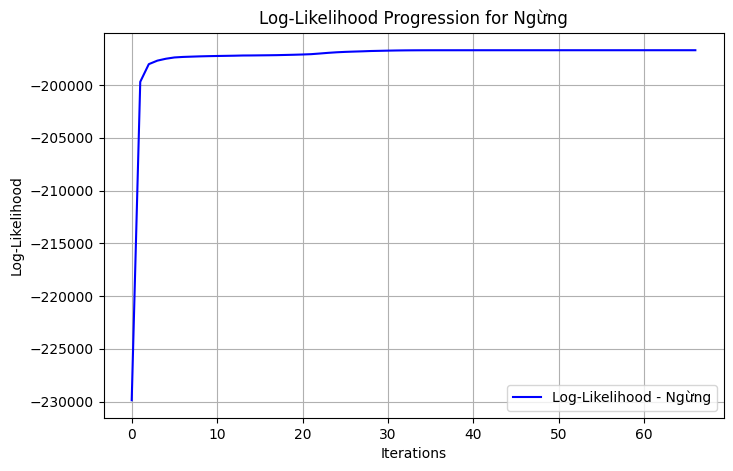

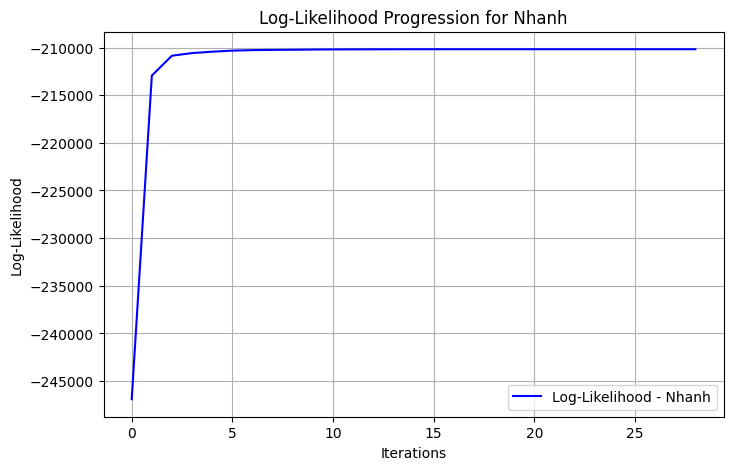

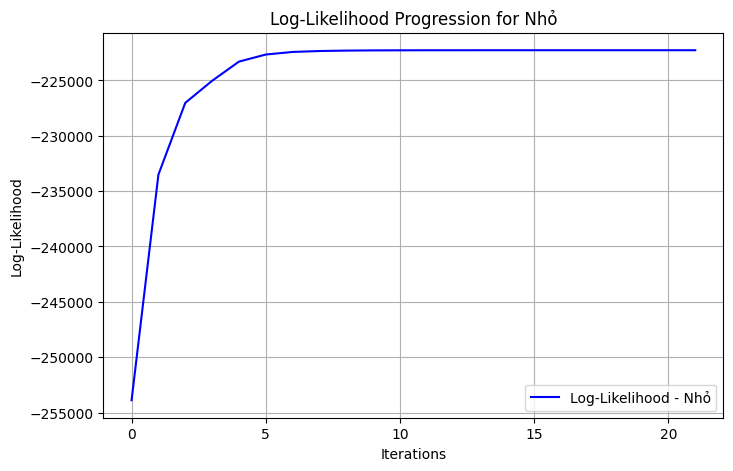

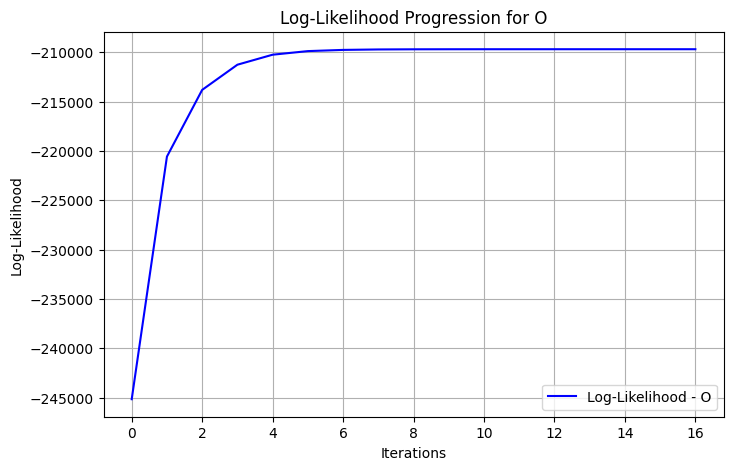

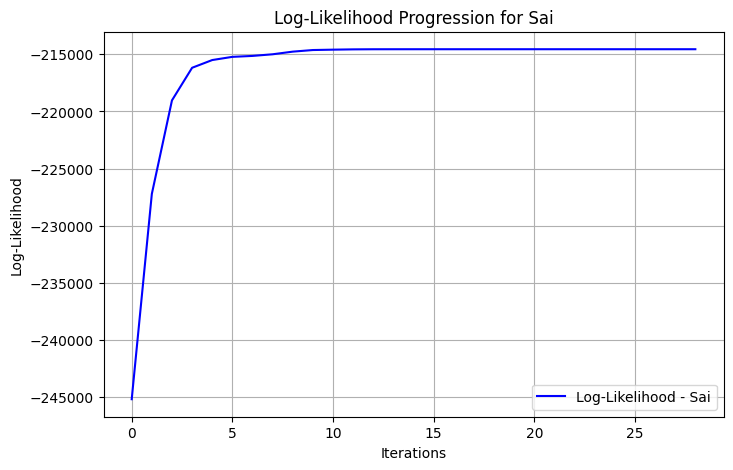

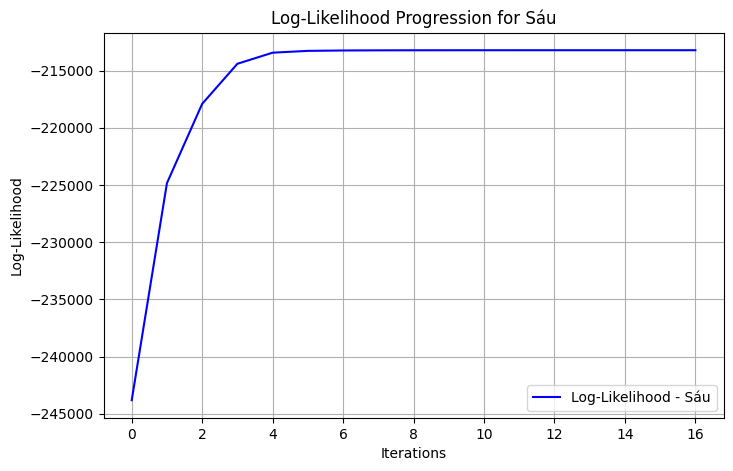

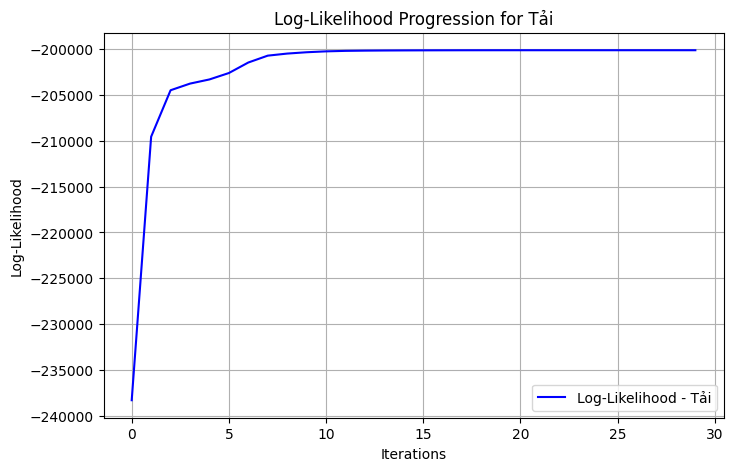

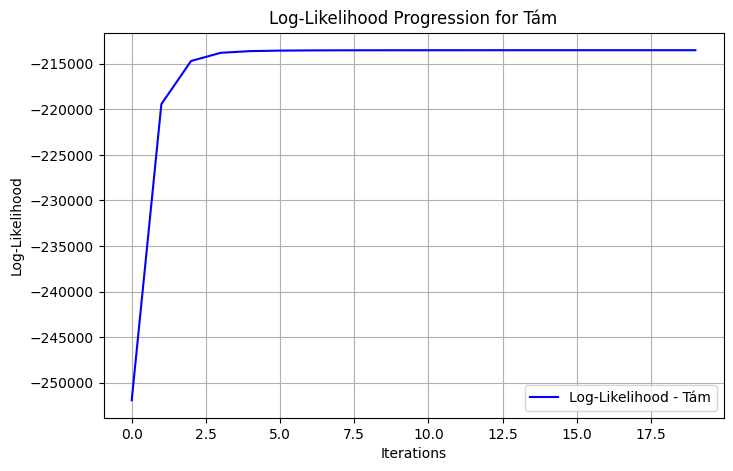

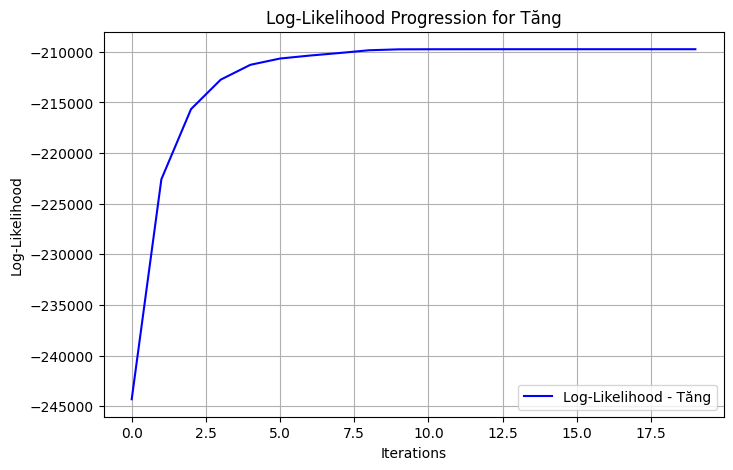

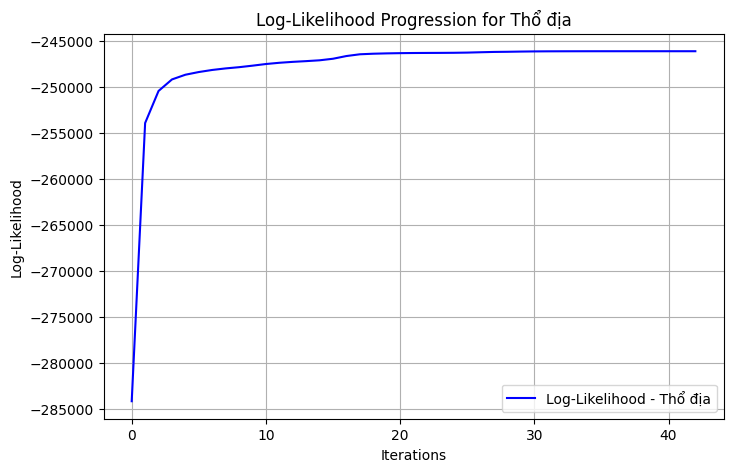

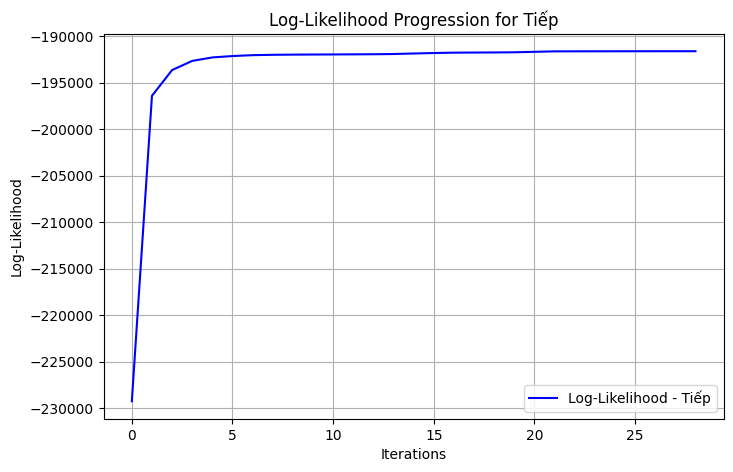

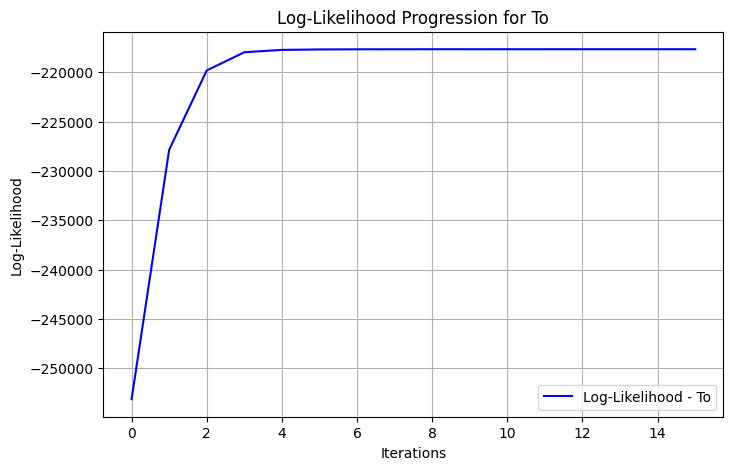

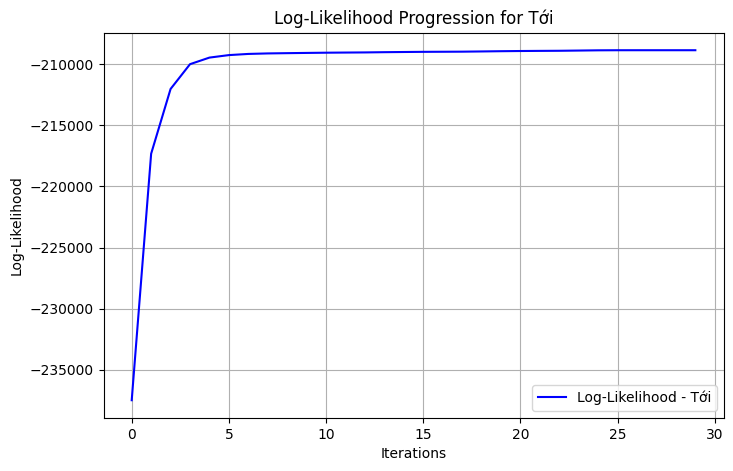

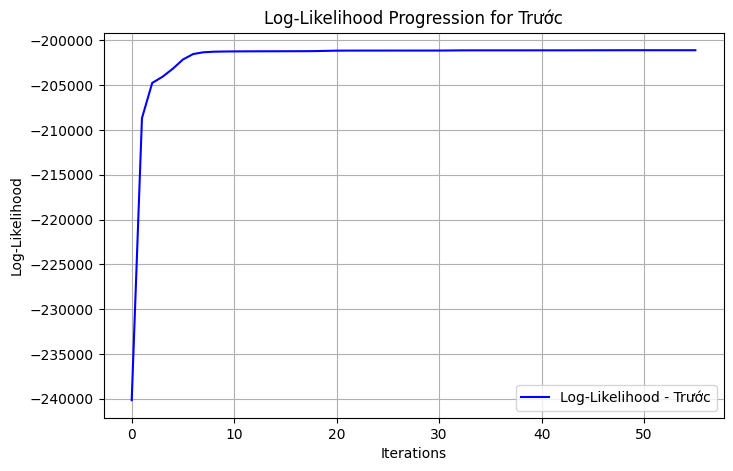

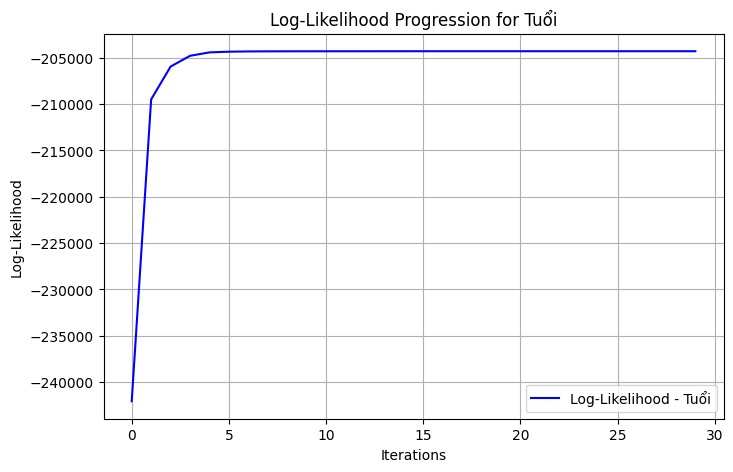

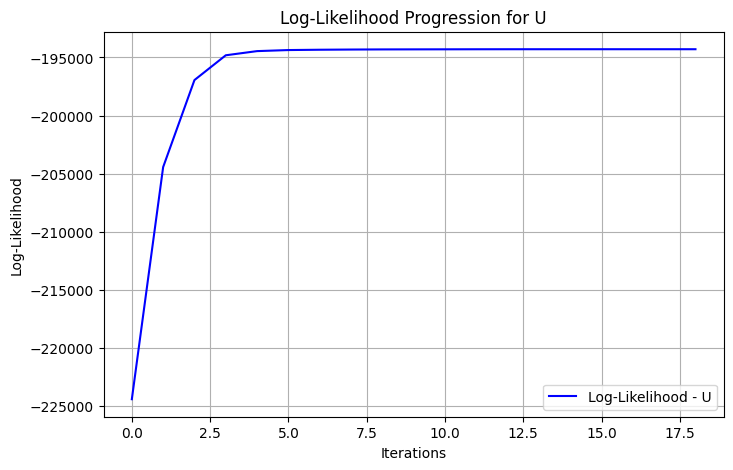

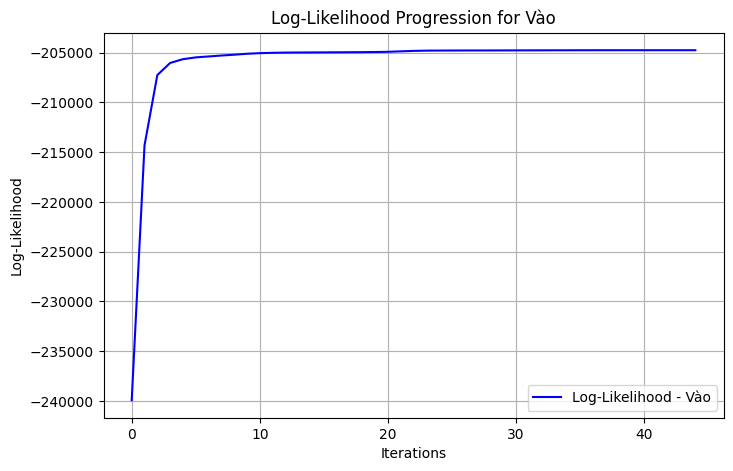

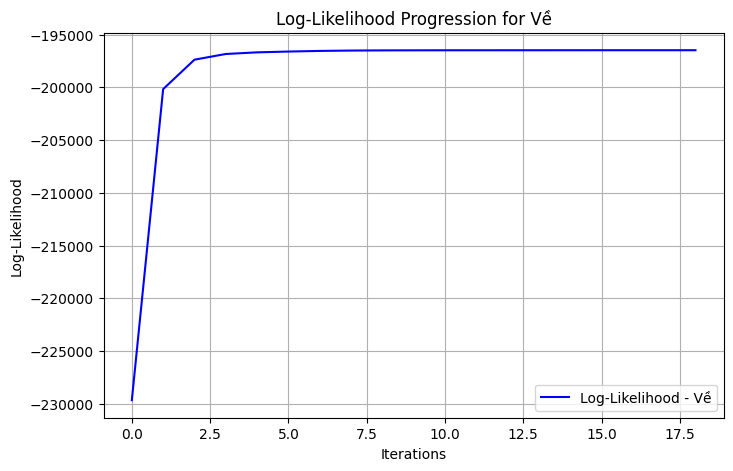

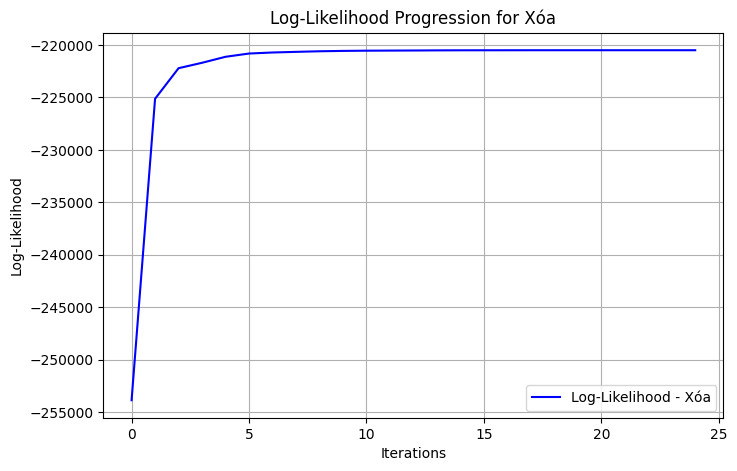

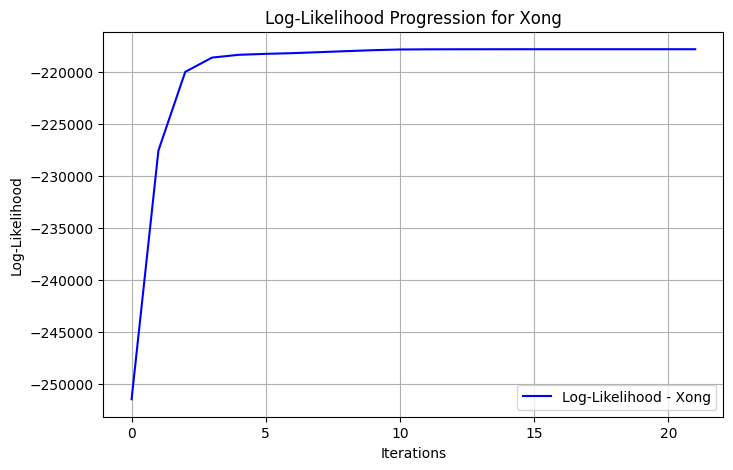

In [19]:
if __name__ == '__main__':
    hmm_train = HMMTraining()
    hmm_train.train()
    hmm_train.save_model()
    hmm_train.evaluation()
    hmm_train.plot_log_likelihood()